
# Multi-Omics Data Exploration and Visualization -- EDA Notebook

This notebook corresponds to the **MultiOmics Assignment 1** using the data from [Table S3](https://github.com/wangbingbo2019/ENCORE-Cancer/tree/main) from Wang et al. (2022). 
The goal is to perform **exploratory data analysis (EDA)** on multi-omics data across multiple cancer types.

**Date:** _2025-10-15_  
**Author:** _Veerendra Gadekar_  

---

## &#128209; Table of Contents
- [Introduction to the Dataset](#intro)
- [Function Library](#fun)
- [Task 1: Data Preparation](#task1)
- [Task 2: CNV Analysis](#task2)
- [Task 3: Multi-omics Integration](#task3)
- [Task 4: Statistical Testing](#task4)
- [Task 5: Visualization Deliverables](#task5)
- [Task 6: Reporting](#task6)

---

<a id='intro'></a>
# Introduction to the Dataset

This dataset originates from Wang et al. (2022) ENCORE-Cancer, profiling multiple omics layers across **15 human cancer types**.
It includes:

-  **Mutation frequency**
-  **Copy number variation (CNV)** (`-2` deep deletion -> `2` amplification)
-  **Differential methylation** (|logFC| and adjusted p-values)
-  **Differential expression** (|logFC| and adjusted p-values)

&#128221; **Reference:**  
Wang B, et al. *ENCORE-Cancer: An atlas of multi-omics profiles across human cancers.*  npj Systems Biology and Applications (2022).  
[https://www.nature.com/articles/s41540-022-00258-1](https://www.nature.com/articles/s41540-022-00258-1)

---

### Cancer Types Covered

- BLCA - Bladder cancer  
- BRCA - Breast cancer
- CESC - Cervical cancer  
- COAD - Colon cancer  
- ESCA - Esophageal cancer  
- GBM - Glioblastoma (brain)  
- HNSC - Head and neck cancer  
- KIRC - Kidney cancer  
- LIHC - Liver cancer  
- LUAD - Lung adenocarcinoma  
- LUSC - Lung squamous cell carcinoma  
- OV - Ovarian cancer  
- PAAD - Pancreatic cancer  
- PRAD - Prostate cancer  
- STAD - Stomach cancer

---

<a id='intro'></a>
# Function Library

Custom functions used throughout the notebook to maintain a clean and reusable analysis workflow.

In [1]:
#---------------------------------------------------------------------------------
# 1. Function to compute descriptive summary statistics for a numeric variable.
#---------------------------------------------------------------------------------

summary_stats <-
  function(x){
      s <- as.list(summary(x));
      o <- data.table::as.data.table(s)
      return(o)
    }

#---------------------------------------------------------------------------------
# 2. Function to visualize mutation frequency distributions and annotate genes 
#    with the highest mutation frequencies. 
#
#    Arguments:
#    1. data      -> Input dataset
#    2. stats     -> Summary statistics table (output of the previous function)
#    3. freq      -> Name of the variable to visualize (here, mutation frequency)
#    4. gp_var    -> Grouping variable (here, cancer type or pan-cancer)
#    5. threshold -> Threshold value for highlighting data points above this value
#---------------------------------------------------------------------------------

plot_mutation_freq <- 
  function(data, stats, freq, gp_var, threshold){
      
      # Identify genes with mutation frequencies greater than or equal to the threshold
      # for annotation on the visualization.
      KeyGenes <-  subset(data, get(freq) >= as.numeric(threshold))
      
      # 'stats' is the output of the previous function. 
      # Add a 'label' column to display summary statistics directly on the plot.
      stats[, label := paste("Max:", round(Max., 2), "\n", 
                             "Mean:", round(Mean, 2), "\n", 
                             "Median:", round(Median, 2), sep = "")]
   
      # Plot the distribution of mutation frequencies as a boxplot with overlaid jitter points.
      # Annotate key genes above the threshold and add summary statistics on the plot.
      ggplot(data, aes(x = !!sym(freq), y = !!sym(gp_var), color = !!sym(gp_var) )) +
        geom_jitter(alpha = 0.5, height = 0.02) +
        geom_boxplot(outlier.shape = NA, alpha = 0.9) +
        geom_text_repel(data = KeyGenes, aes(label = Gene), size = 4, box.padding = 0.5, point.padding = 0.3) +
        geom_text(data = stats, aes(x = max(stats$Max.) + 0.05, label = label), 
                  color = "black", hjust = 0, size = 3) +   
        geom_text(data = data[, .(uniqueN(Gene)), gp_var], 
                  aes(x = -0.06, y = !!sym( gp_var), label = paste0("n=", V1)), 
                  color = "black", size = 4, vjust=0, hjust=0) +

      # Add axis labels and theme elements.
        labs(title = "Mutation Frequency by Cancer Type", 
             x = "Mutation Frequency", 
             y = "Cancer Type") +
        theme_minimal(base_size = 16) +
        theme(axis.text.y = element_text(size = 14), legend.position = "none")
    }

#---------------------------------------------------------------------------------
# 3. Function to visualize CNV (Copy Number Variation) frequency distributions 
#    using boxplots and jittered points. Summary statistics can be annotated 
#    on the plot for better interpretability.
#
#    Arguments:
#    1. data   -> Input dataset containing CNV frequencies.
#    2. stats  -> Summary statistics table (output of summary_stats function).
#    3. gp_var -> Grouping variable (cancer type or pan-cancer).
#---------------------------------------------------------------------------------

plot_CNV_freq <- 
  function(data, stats, gp_var){
      
      # Plot CNV frequency distributions as boxplots with overlaid jitter points 
      # to visualize individual data values and their spread.
      ggplot(data, aes(y = variable, x = value, fill = variable)) +
        geom_jitter(alpha = 0.4, height = 0.02, aes(color = variable)) +
        geom_boxplot(outlier.shape = NA, alpha = 0.7) +
        
        # Annotate summary statistics on the plot using the 'label' column in 'stats'.
        geom_text(data = stats, 
                  aes(x = max(stats$Max.) + 0.02, label = label), 
                  color = "black", hjust = 0, size = 4) +
        
        # Limit the x-axis between 0 and 1 to standardize visualization across groups.
        scale_x_continuous(limits = c(0, 1)) +
        
        # Create separate panels for each group defined by 'gp_var'.
        facet_wrap(~ get(gp_var), ncol = 3, scales = "free_x") +
        
        # Add axis labels and theme elements.
        labs(title = "CNV Frequency by Cancer Type", 
             y = "CNV Event Type", 
             x = "CNV Frequency") +
        theme_minimal(base_size = 14) +
        theme(legend.position = "none")
  }

#---------------------------------------------------------------------------------
# 4. Function to generate Volcano plots for visualizing differential gene expression.
#    It highlights genes based on fold-change and p-value thresholds, and annotates
#    selected key genes.
#
#    Arguments:
#    1. data       -> Input dataset.
#    2. pv         -> Column name representing the p-value.
#    3. fcz        -> Column name representing log fold-change (Z-score or logFC).
#    4. title      -> Plot title.
#    5. fc_thresh  -> Fold-change threshold for significance.
#    6. pv_thresh  -> P-value threshold for significance.
#    7. keyGenes   -> Subset of genes to annotate on the plot (data frame).
#---------------------------------------------------------------------------------

plot_volcano <- 
  function(data, pv, fcz, title, fc_thresh, pv_thresh, keyGenes) {
      
      # Classify each gene as Significant or Not Significant 
      # based on p-value and fold-change thresholds.
      data[, Significant := ifelse(
        get(pv) < as.numeric(pv_thresh) & abs(get(fcz)) >= as.numeric(fc_thresh),
        "Significant", 
        "Not Significant"
      )]
      
      # Categorize genes into groups for color-coding in the plot.
      # Groups:
      # - "p-value and logFC": meets both thresholds
      # - "p-value": only p-value threshold
      # - "Log_FC": only logFC threshold
      # - "NS": not significant
      data[, Group := fifelse(get(pv) < pv_thresh & abs(get(fcz)) > fc_thresh, "p-value and logFC",
                        fifelse(get(pv) < pv_thresh & abs(get(fcz)) < fc_thresh, "p-value",
                        fifelse(abs(get(fcz)) > fc_thresh & get(pv) > pv_thresh, "Log_FC", "NS")))]
      
      # Volcano plot
      ggplot(data, aes(x = !!sym(fcz), y = -log10(!!sym(pv)), color = Group)) +
        
        # Plot individual data points
        geom_point(alpha = 0.7, size = 2) +
        
        # Color scheme for groups
        scale_color_manual(values = c(
          "NS" = "grey50", 
          "Log_FC" = "seagreen3", 
          "p-value" = "deepskyblue2", 
          "p-value and logFC" = "red"
        )) +
        
        # Add threshold lines for p-value and fold-change
        geom_hline(yintercept = -log10(pv_thresh), linetype = "dashed", color = "black") +
        geom_vline(xintercept = c(-fc_thresh, fc_thresh), linetype = "dashed", color = "black") +
        
        # Facet by cancer type if present
        facet_wrap(~ cancer_type) +
        
        # Annotate key genes above the threshold and add summary statistics on the plot.
        geom_text_repel(data = keyGenes, aes(label = Gene), 
          color = "black", size = 4, max.overlaps = 15) +
        
        # Add axis labels and theme elements.
        labs(
          title = paste("Volcano Plot:", title),
          x = "Z-score (logFC)", 
          y = "−Log10 adjusted P-value", color = "Group"
        ) +
        theme_minimal(base_size = 16)
  }


# ----------------------------------------------------------
# 5. Function to create_upset_and_get_unique_genes
#    Purpose: 
#    1. Create binary presence matrix for top CNV genes (CNV_2 or CNV_-2)
#    2. Generate an UpSet plot to visualize gene intersections across cancer types
#    3. Return genes uniquely present in a specified combination of cancer types
#
#    Arguments:
#    top10_cnv_df  -> long-format top CNV data.table (with 'present' column)
#    cnv_var       -> CNV variable to use ("CNV_2_frequency" or "CNV_-2_frequency")
#    combo         -> character vector of cancer types to check for unique intersection
#
#    Returns:
#    A list containing:
#     - binary_matrix   : gene × cancer_type binary matrix
#     - unique_genes    : genes uniquely present in the specified combo
# ----------------------------------------------------------

create_upset_and_get_unique_genes <- function(top10_cnv_df, cnv_var, combo) {

  # Create a binary presence/absence indicator
  #    - 'present' = 1 if CNV_2 frequency > 0, else 0
  #    - This helps convert CNV frequencies into a binary matrix for intersection analysis    
  top10_cnv_df[, present := as.integer(value > 0)]
  
  # Create wide binary matrix
  freq_mat <- dcast(
    subset(top10_cnv_df, variable == cnv_var),
    Gene ~ cancer_type,
    value.var = "present",
    fill = 0
  )
  
  mat <- as.matrix(freq_mat[, -1, with = FALSE])
  rownames(mat) <- freq_mat$Gene
  
  # UpSet plot
  toplot <- 
  upset(
    as.data.frame(mat),
    nsets = uniqueN(top10_cnv_df$cancer_type),
    order.by = "freq",
    main.bar.color = "steelblue",
    sets.bar.color = "darkred",
    keep.order = TRUE
  )
  
  # Identify genes uniquely present in specified combination
  unique_genes <- rownames(mat)[
    apply(mat[, combo, drop = FALSE], 1, function(x) all(x == 1)) &
    apply(mat[, setdiff(colnames(mat), combo), drop = FALSE], 1, function(x) all(x == 0))
  ]
  
  # Return both matrix and gene list
  return(list(
    plot = toplot,
    binary_matrix = mat,
    unique_genes = unique_genes
  ))
}

#---------------------------------------------------------------------------------
# 6. Function: compute_spearman_correlation
#    Computes Spearman correlation between two variables, optionally grouped by a factor.
#
#    Arguments:
#     data         -> data.table or data.frame
#     xvar         -> character, name of the first variable (e.g., "CNV_burden")
#     yvar         -> character, name of the second variable (e.g., "De_logFC_z")
#     group_var    -> character, optional name of grouping variable (e.g., "cancer_type")
#
#    Returns:
#     A data.table with columns:
#     - group_var
#     - corr (Spearman correlation)
#     - pval (p-value)
#     - label (formatted text for plotting)
#---------------------------------------------------------------------------------
compute_groupwise_spearman <- function(data, xvar, yvar, group_var){
  
  # Ensure data.table for fast grouping
  dt <- data.table::as.data.table(data)
  
  # Compute correlation by group
  result <- dt[,{
      test <- suppressWarnings(
        cor.test(get(xvar), get(yvar), method = "spearman", use = "complete.obs"))
      list(
        corr = test$estimate,
        pval = test$p.value,
        label = paste0(
          "rho = ", round(test$estimate, 2),
          "\np = ", formatC(test$p.value, format = "e", digits = 2)
        ))}, by = group_var]
  
  return(result)
}
          
          
#---------------------------------------------------------------------------------
# 7. Function plot_correlation_scatter
#    Description:
#    Generates a scatter plot with a linear trend line and a text annotation
#    showing Spearman correlation statistics.
#
#    Arguments:
#    data        -> data.table or data.frame containing the variables to plot
#    xvar        -> character, name of the variable for the x-axis
#    yvar        -> character, name of the variable for the y-axis
#    corr_data   -> data.table containing the correlation result with 'label' column
#    plot_title  -> character, title for the plot
#---------------------------------------------------------------------------------
plot_correlation_scatter <- function(data, xvar, yvar, corr_data, plot_title, gp_var){
  ggplot(data, aes(x = !!sym(xvar), y = !!sym(yvar))) +
    geom_point(alpha = 0.4, color = "deepskyblue2") +
    geom_smooth(method = "lm", color = "red", se = FALSE, linetype = "dashed") +
    facet_wrap(~ get(gp_var)) +
    geom_text(
      data = corr_data,
      aes(x = -Inf, y = Inf, label = label),
      hjust = -0.1, vjust = 1.2,
      inherit.aes = FALSE
    ) +
    labs(
      title = plot_title,
      x = xvar,
      y = yvar
    ) +
    theme_minimal(base_size = 16)
}          


<a id='task1'></a>
# Task 1: Data Preparation

**Assignment requirement:**  
- Load the dataset and check its structure.  
- Perform basic summary statistics, pan-cancer and across each cancer type:  
  - Distribution of mutation frequencies across all genes  
  - Distribution of CNV events (CNV_-2 … CNV_2)  
  - Distribution of methylation and expression |logFC| values  
  - Derive inferences if any.

---


In [2]:
#---------------------------------------------------------------------------------
# Load required R packages for data manipulation and visualization
#---------------------------------------------------------------------------------
library(data.table)
library(ggplot2)
library(readxl)
library(ggrepel)
library(ggridges)
library(UpSetR)

#---------------------------------------------------------------------------------
# Display package versions for reproducibility
#---------------------------------------------------------------------------------
sapply(
  c("data.table", "ggplot2", "readxl", "ggrepel", "ggridges", "UpSetR"), 
  function(pkg) paste0("V", packageVersion(pkg))
)

data.table    ggplot2     readxl    ggrepel   ggridges     UpSetR 
 "V1.17.4"   "V3.5.2"   "V1.4.5"   "V0.9.6"   "V0.5.6"   "V1.4.0"

In [3]:
#---------------------------------------------------------------------------------
# Read and combine all sheets from an Excel file into a single data.table object
#---------------------------------------------------------------------------------

# Get all sheet names from the Excel file
sheets <- excel_sheets("Table S3.xlsx")

# Read each sheet into a data.table and add the sheet name as a new column 'cancer_type'
data_list <- 
    lapply(
      sheets,
      function(sheet_name){
        o <- setDT(read_excel("Table S3.xlsx", sheet = sheet_name))
        o[, cancer_type := sheet_name]
        return(o)
      }
    )

# Combine all sheet-level data.tables into a single consolidated table
data_combined <- rbindlist(data_list)

# Add a column to indicate pan-cancer analysis
data_combined[, `pan-cancer` := "pan-cancer"]

In [4]:
#---------------------------------------------------------------------------------
# Inspect data structure 
#---------------------------------------------------------------------------------
str(data_combined)

Classes ‘data.table’ and 'data.frame':	241977 obs. of  13 variables:
 $ Gene              : chr  "ATRX" "TCOF1" "NSRP1" "OPA3" ...
 $ Mutation_frequency: num  0.05303 0.01768 0.00505 0.00758 0.03283 ...
 $ CNV_-2            : num  3 1 1 0 0 5 2 5 2 6 ...
 $ CNV_-1            : num  80 188 28 54 14 160 22 50 77 164 ...
 $ CNV_0             : num  271 191 205 192 180 198 192 201 193 186 ...
 $ CNV_1             : num  53 27 156 152 198 44 186 137 125 48 ...
 $ CNV_2             : num  1 1 18 10 16 1 6 15 11 4 ...
 $ Me_|logFC|        : num  0.0932 0 0.0186 0 0.0168 ...
 $ Me_adj.P-value    : num  0.002477 0 0.000278 0 0.020927 ...
 $ De_|logFC|        : num  0.695 0.564 0.489 0 0 ...
 $ De_adj.P-value    : num  1.01e-06 4.00e-04 1.04e-05 0.00 0.00 ...
 $ cancer_type       : chr  "BLCA" "BLCA" "BLCA" "BLCA" ...
 $ pan-cancer        : chr  "pan-cancer" "pan-cancer" "pan-cancer" "pan-cancer" ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Distribution of mutation frequencies

pan-cancer Min. 1st Qu. Median      Mean        3rd Qu.    Max.     
1 pan-cancer 0    0       0.004032258 0.008988393 0.01234568 0.8695652

Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


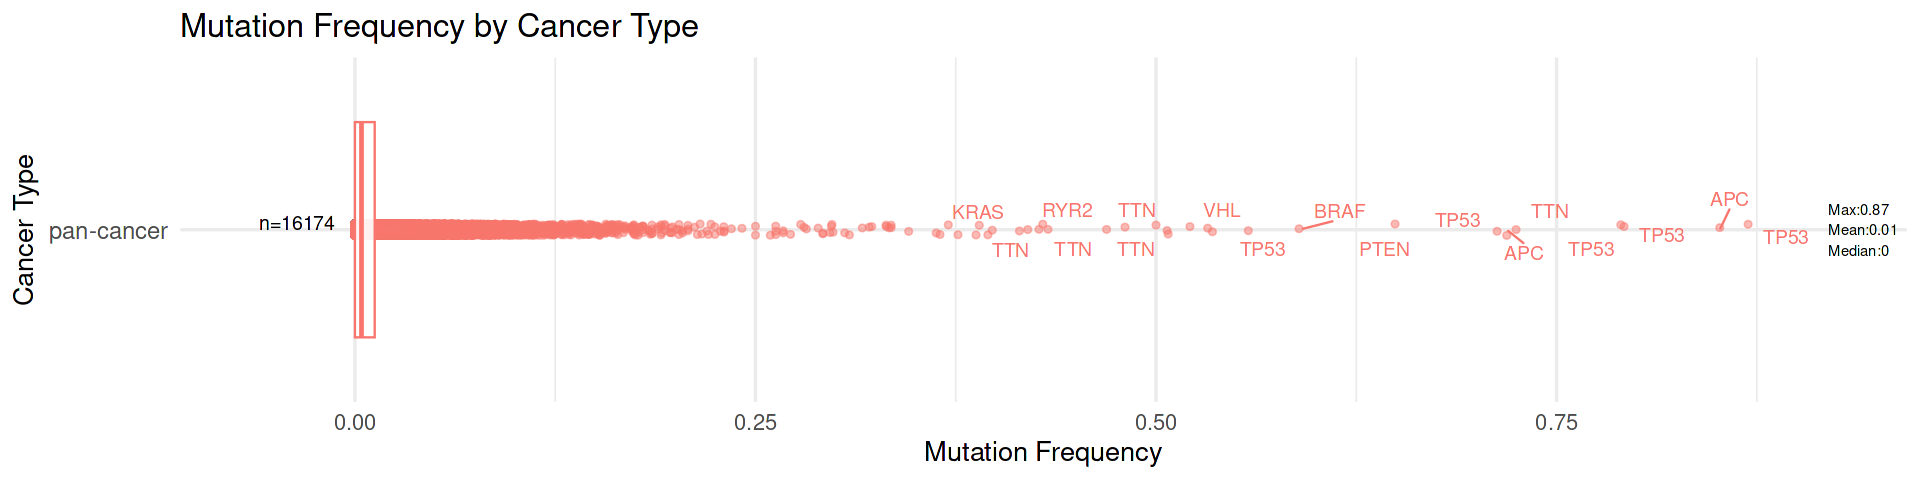

In [5]:
#---------------------------------------------------------------------------------
# Inspect data structure and compute summary statistics
#---------------------------------------------------------------------------------

# Compute summary statistics for 'Mutation_frequency' across pan-cancer
pan_cancer_stats <- data_combined[, summary_stats(Mutation_frequency), by = "pan-cancer"]

# Display the summary statistics pan-cancer
pan_cancer_stats

#---------------------------------------------------------------------------------
# Plot mutation frequency distribution for pan-cancer
#---------------------------------------------------------------------------------

# Set plot dimensions for better visualization
options(repr.plot.width = 16, repr.plot.height = 4)

# Generate mutation frequency distribution plot
plot_mutation_freq(data_combined, pan_cancer_stats, "Mutation_frequency", "pan-cancer", "0.40")

In [6]:
# Derive total number of samples per gene and cancer type 
# by summing across all CNV event categories (-2 to +2)
data_combined[, sample_count := (`CNV_-2` + `CNV_-1` + CNV_0 + CNV_1 + CNV_2), cancer_type]
sample_counts <- data_combined[, .(sample_count = max(sample_count)), by = cancer_type]
sample_counts[order(-sample_count)]

cancer_type sample_count
1  BRCA        1080        
2  UCEC         539        
3  KIRC         528        
4  HNSC         522        
5  LUAD         516        
6  LUSC         501        
7  THCA         499        
8  PRAD         492        
9  COAD         451        
10 BLCA         408        
11 LIHC         370        
12 KIPR         288        
13 ESCA         184        
14 READ         165        
15 CHOL          36

In [7]:
# Compute per-gene mutation frequencies across all cancers
# (aggregate median and mean and weighted mean mutation frequency per gene)
# Weighted means provide a more realistic summary statistic when combining data with differing sample sizes
median_mut_freq = data_combined[, 
                        .(Median_Mutation_frequency = median(Mutation_frequency), 
                          Mean_Mutation_frequency = mean(Mutation_frequency),
                          Weighted_Mean_Mutation_frequency = sum(Mutation_frequency * sample_count) / 
                                                             sum(sample_count)), by = Gene]

# View the top 20 genes ranked by highest median mutation frequency
head(median_mut_freq[rev(order(Median_Mutation_frequency))], 20)

Gene   Median_Mutation_frequency Mean_Mutation_frequency
1  TTN    0.33168317                0.33044309             
2  TP53   0.29735234                0.39184724             
3  MUC16  0.18548387                0.18229310             
4  RYR2   0.13043478                0.13542439             
5  SYNE1  0.12338858                0.12774595             
6  LRP1B  0.11868687                0.12350551             
7  FLG    0.11523438                0.09840274             
8  PCLO   0.11111111                0.09651966             
9  DNAH5  0.11111111                0.09045118             
10 OBSCN  0.10674157                0.09990218             
11 XIRP2  0.09900990                0.09265698             
12 FAT3   0.09848485                0.08313316             
13 USH2A  0.09239130                0.10773961             
14 PIK3CA 0.08695652                0.14006228             
15 APOB   0.08585859                0.08538388             
16 MUC4   0.08426966                0.10717732             
17 GPR98  0.08333333                0.07966641             
18 MUC5B  0.08203125                0.08317449             
19 ZFHX4  0.08007812                0.10051580             
20 DST    0.07865169                0.08008736             
   Weighted_Mean_Mutation_frequency
1  0.31883508                      
2  0.37090058                      
3  0.17900204                      
4  0.13689682                      
5  0.11883198                      
6  0.12062057                      
7  0.09623819                      
8  0.09202589                      
9  0.08020143                      
10 0.09204597                      
11 0.09229102                      
12 0.08381026                      
13 0.11408159                      
14 0.17132201                      
15 0.07942307                      
16 0.08349911                      
17 0.07424544                      
18 0.08049138                      
19 0.10657917                      
20 0.08177773

In [8]:
#---------------------------------------------------------------------------------
# Display the summary statistics for each cancer-type
#---------------------------------------------------------------------------------

cancer_type_stats <- data_combined[, summary_stats(Mutation_frequency), by = cancer_type]
cancer_type_stats <- cancer_type_stats[rev(order(Median))]
cancer_type_stats

cancer_type Min. 1st Qu.     Median      Mean         3rd Qu.     Max.     
1  UCEC        0    0.008064516 0.020161290 0.0230117442 0.032258065 0.6491935
2  LIHC        0    0.009900990 0.014851485 0.0182202778 0.024752475 0.3316832
3  COAD        0    0.004608295 0.009216590 0.0161904191 0.023041475 0.7188940
4  BLCA        0    0.002525253 0.007575758 0.0118118167 0.015151515 0.5075758
5  LUAD        0    0.003683241 0.007366483 0.0122028923 0.014732965 0.5211786
6  LUSC        0    0.000000000 0.005617978 0.0132268154 0.016853933 0.7921348
7  ESCA        0    0.000000000 0.005434783 0.0072340179 0.010869565 0.8695652
8  HNSC        0    0.001953125 0.003906250 0.0072721322 0.009765625 0.7128906
9  BRCA        0    0.001018330 0.002036660 0.0031825885 0.004073320 0.3167006
10 PRAD        0    0.000000000 0.002004008 0.0023003089 0.004008016 0.1422846
11 THCA        0    0.000000000 0.000000000 0.0007908698 0.001984127 0.5892857
12 READ        0    0.000000000 0.000000000 0.0102384587 0.012345679 0.8518519
13 KIPR        0    0.000000000 0.000000000 0.0032330734 0.005952381 0.1428571
14 KIRC        0    0.000000000 0.000000000 0.0027651281 0.004694836 0.5352113
15 CHOL        0    0.000000000 0.000000000 0.0031132199 0.000000000 0.3333333

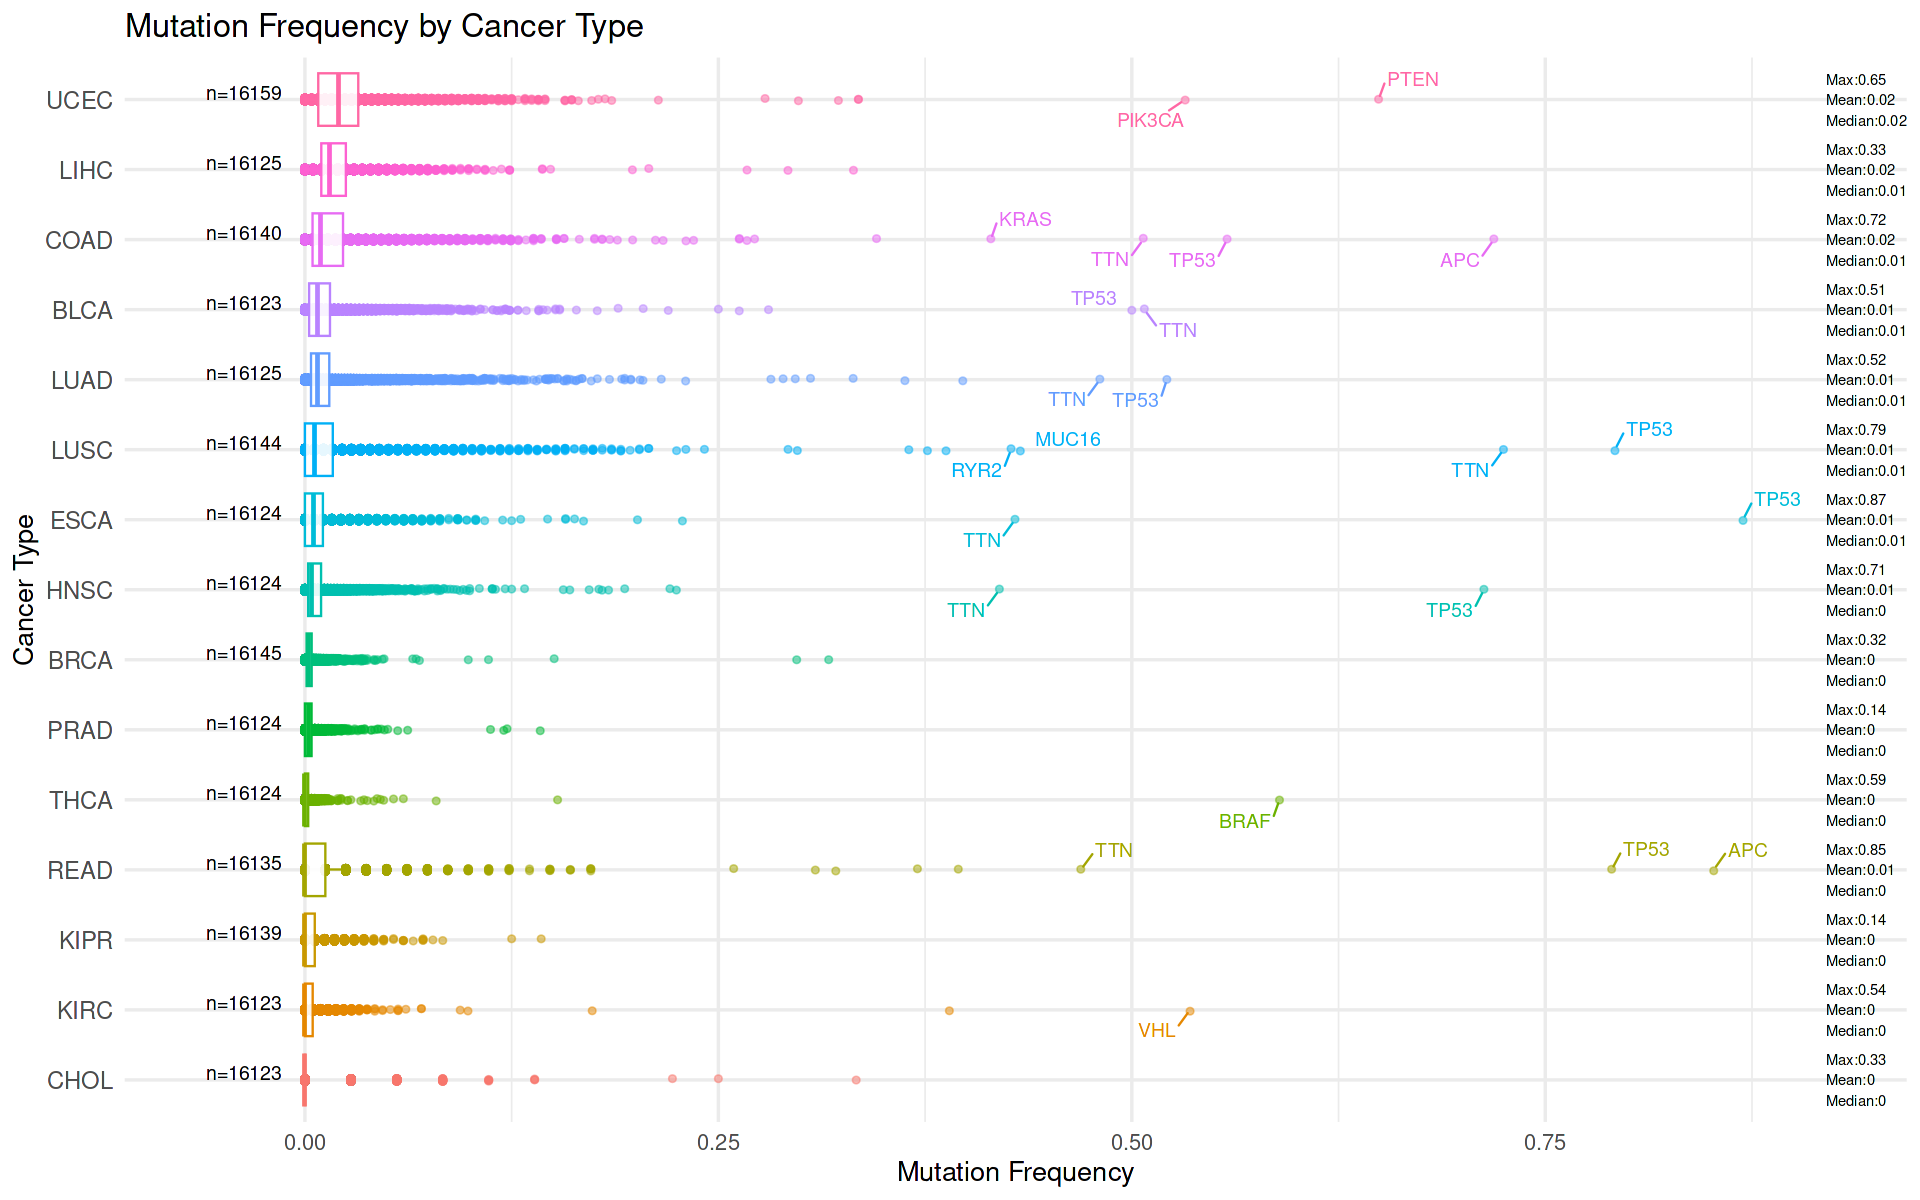

In [9]:
#---------------------------------------------------------------------------------
# Plot mutation frequency distribution by cancer type
#---------------------------------------------------------------------------------

# Reorder cancer_type factor levels based on summary statistics 
# (using 'rev()' ensures the plot shows in descending order)
data_combined[, cancer_type := factor(cancer_type, level = rev(cancer_type_stats$cancer_type))]

# Set plot dimensions for better readability
options(repr.plot.width = 16, repr.plot.height = 10)

# Generate mutation frequency distribution plot by cancer type
plot_mutation_freq(data_combined, cancer_type_stats, "Mutation_frequency", "cancer_type", "0.40")

###  Key Inferences
- Different cancer types have widely varying mutation frequencies, indicating heterogeneity in genetic alteration rates
- Cancer types with higher mutational burden may be better candidates for immunotherapy, as high mutation load is linked to increased immune recognition
- Certain key genes (like TP53, TTN, APC, MUC16, KRAS, and PIK3CA) frequently mutated across multiple cancers could act as driver mutations for disease progression and therapy targeting
- Identifying such commonly mutated genes can guide future research, help prioritize candidate genes for functional validation studies, and support the development of targeted therapies.
- Given that some highly mutated genes may be long passenger genes, integrating mutation recurrence with external driver gene databases (e.g., COSMIC) or pathway annotation can help prioritize biologically relevant alterations

## Distribution of CNV events

In [10]:
#---------------------------------------------------------------------------------
# Preparing CNV data
#---------------------------------------------------------------------------------

# Calculate CNV counts (row-wise)
data_combined[, CNV := `CNV_-2` + `CNV_-1` + CNV_1 + CNV_2]

# Calculate CNV frequencies
data_combined[, `:=`(
  CNV_frequency       = CNV/sample_count,
  `CNV_-2_frequency`  = `CNV_-2`/sample_count,
  `CNV_-1_frequency`  = `CNV_-1`/sample_count,
  CNV_2_frequency     = `CNV_2`/sample_count,
  CNV_1_frequency     = `CNV_1`/sample_count
)]

# Subset relevant columns
data_combined_cnv = subset(data_combined, 
                           select = c("CNV_-2_frequency","CNV_-1_frequency",
                                      "CNV_1_frequency","CNV_2_frequency", 
                                      "Gene","cancer_type","pan-cancer"))

# Add gene counts for labeling
data_combined_cnv[, V1 := uniqueN(Gene), by = cancer_type]
data_combined_cnv[, V2 := uniqueN(Gene), by = `pan-cancer`]
data_combined_cnv[, cancer_type := paste0(cancer_type, " (n=", V1, ")")]
data_combined_cnv[, `pan-cancer` := paste0(`pan-cancer`, " (n=", V2, ")")]

# Remove temp columns and NAs
data_combined_cnv = data_combined_cnv[!is.na(CNV_2_frequency), .SD, .SDcols = !c("V1","V2")]

In [11]:
# ----------------------------------------------------------
# Summary statistics for CNV frequency features (pan-cancer)
# ----------------------------------------------------------

# Define the set of CNV frequency variables to summarize
CNV_class = c("CNV_-2_frequency", "CNV_-1_frequency", "CNV_1_frequency", "CNV_2_frequency")

# Loop through each CNV class and calculate summary statistics (Min, Max, Mean, Median, etc.)
# by 'pan-cancer' group. Combine all results into a single data.table using rbindlist.
pan_cancer_stats = rbindlist(
  lapply(CNV_class, function(x) { 
    cancer_type_stats <- data_combined_cnv[, summary_stats(get(x)), by = `pan-cancer`]
    
    # Order by Median value (descending) for easier interpretation in visualization
    cancer_type_stats <- cancer_type_stats[rev(order(Median))]
    
    # Add variable name to track which CNV class each row corresponds to
    cancer_type_stats$variable = x
    cancer_type_stats
  })
)

# Create a formatted label string containing key summary metrics for annotation in plots
pan_cancer_stats[, label := paste("Min:", round(Min., 2), ";", "Max:", round(Max., 2), "\n",
                                  "Mean:", round(Mean, 2), ";", "Median:", round(Median, 2), sep = "")]


Warning message:
“Removed 100544 rows containing missing values or values outside the scale range (`geom_point()`).”


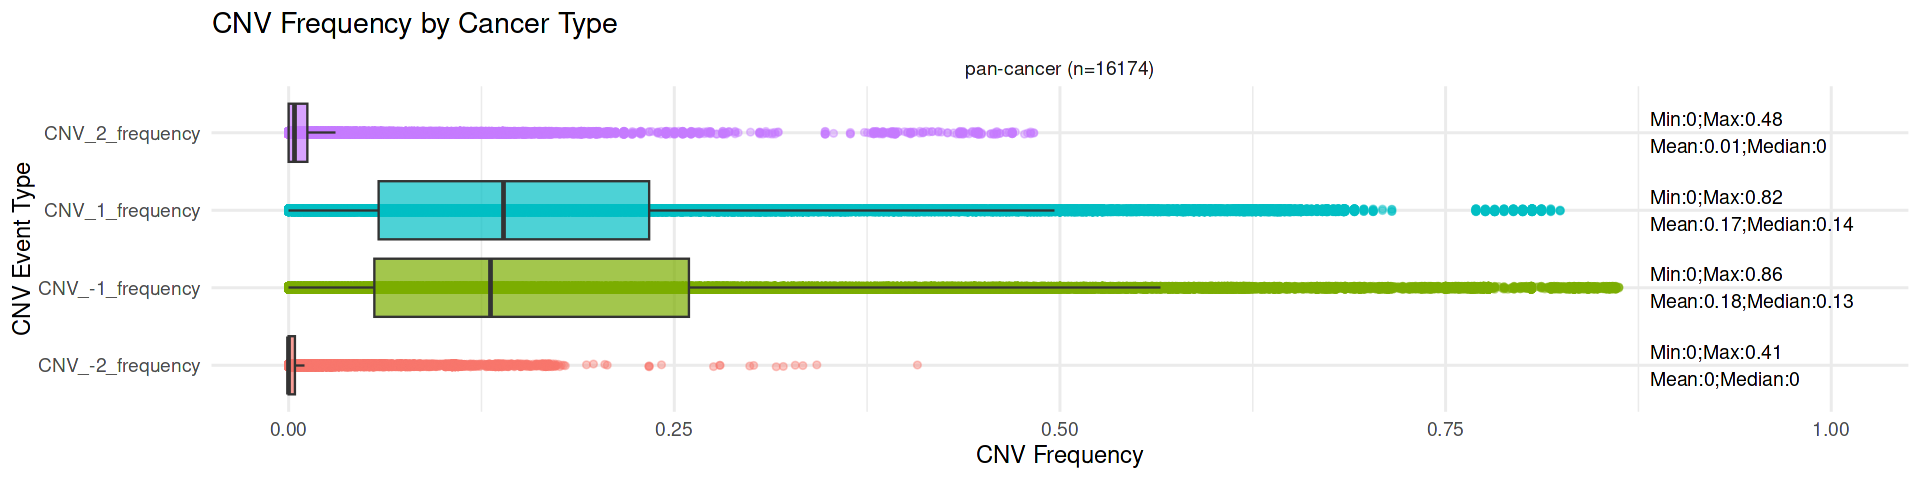

In [12]:
# ----------------------------------------------------------
# CNV frequency distribution plot (Pan-cancer)
# ----------------------------------------------------------

# Reshape CNV data from wide to long format
# Converts CNV frequency columns into a 'variable' and 'value' column
# This makes it easier to plot multiple CNV classes in a single ggplot
data_combined_cnv_tp = melt(
  data_combined_cnv,
  id.vars = c("Gene", "cancer_type", "pan-cancer")
)

# Set figure size for better visualization
options(repr.plot.width = 16, repr.plot.height = 4)

# Generate CNV frequency distribution plot for pan-cancer level
# 'pan_cancer_stats' from above provides summary statistics for annotating the plot
plot_CNV_freq(data_combined_cnv_tp, pan_cancer_stats, "pan-cancer")


In [13]:
# ----------------------------------------------------------
# Summary statistics for CNV frequency features by cancer type
# ----------------------------------------------------------

# Loop through each CNV frequency variable defined in CNV_class
# For each variable:
#   - Compute summary statistics (Min, Max, Mean, Median, etc.)
#      grouped by 'cancer_type'
#   - Sort results in descending order of Median values
#   - Add the variable name to keep track of which CNV class each row corresponds to
# Combine all results from the loop into a single data.table with rbindlist

cancer_type_stats <- 
    rbindlist(
      lapply(CNV_class, function(x) { 
        cancer_type_stats <- data_combined_cnv[, summary_stats(get(x)), by = cancer_type]
        cancer_type_stats <- cancer_type_stats[rev(order(Median))]
        cancer_type_stats$variable = x
        cancer_type_stats
      })
    )

# Sort the resulting summary table by cancer type name 
cancer_type_stats[order(cancer_type)]

# Create a label column with formatted summary statistics for easy annotation in plots
# (e.g., Min, Max, Mean, Median values)
cancer_type_stats[, label := paste(
  "Min:", round(Min., 2), ";", "Max:", round(Max., 2), "\n",
  "Mean:", round(Mean, 2), ";", "Median:", round(Median, 2),
  sep = ""
)]

cancer_type    Min.        1st Qu.      Median      Mean         3rd Qu.    
1  BLCA (n=16123) 0.000000000 0.0000000000 0.002450980 0.0066897384 0.007352941
2  BLCA (n=16123) 0.004901961 0.1225490196 0.203431373 0.2363065997 0.352941176
3  BLCA (n=16123) 0.039215686 0.1250000000 0.193627451 0.2308638346 0.330882353
4  BLCA (n=16123) 0.000000000 0.0049019608 0.012254902 0.0181382696 0.022058824
5  BRCA (n=16145) 0.000000000 0.0009259259 0.001851852 0.0037484940 0.004629630
6  BRCA (n=16145) 0.012037037 0.1416666667 0.211111111 0.2262889191 0.294444444
7  BRCA (n=16145) 0.048148148 0.1166666667 0.162962963 0.2009417343 0.228703704
8  BRCA (n=16145) 0.000000000 0.0046296296 0.010185185 0.0221359350 0.019444444
9  CHOL (n=16123) 0.000000000 0.0000000000 0.000000000 0.0016167626 0.000000000
10 CHOL (n=16123) 0.000000000 0.0833333333 0.166666667 0.2316371697 0.333333333
11 CHOL (n=16123) 0.000000000 0.0833333333 0.138888889 0.1663289429 0.222222222
12 CHOL (n=16123) 0.000000000 0.0000000000 0.000000000 0.0147538569 0.027777778
13 COAD (n=16140) 0.000000000 0.0000000000 0.000000000 0.0031576700 0.004434590
14 COAD (n=16140) 0.000000000 0.0842572062 0.121951220 0.1575420792 0.223946785
15 COAD (n=16140) 0.013303769 0.0776053215 0.166297118 0.1793459331 0.206208426
16 COAD (n=16140) 0.000000000 0.0000000000 0.002217295 0.0050124659 0.004434590
17 ESCA (n=16124) 0.000000000 0.0000000000 0.000000000 0.0059068070 0.005434783
18 ESCA (n=16124) 0.010869565 0.1467391304 0.266304348 0.2724628074 0.358695652
19 ESCA (n=16124) 0.027173913 0.1521739130 0.228260870 0.2506140183 0.309782609
20 ESCA (n=16124) 0.000000000 0.0054347826 0.016304348 0.0254833417 0.032608696
21 HNSC (n=16124) 0.000000000 0.0000000000 0.001915709 0.0037337924 0.003831418
22 HNSC (n=16124) 0.005747126 0.0938697318 0.159003831 0.1918818448 0.247126437
23 HNSC (n=16124) 0.017241379 0.1111111111 0.166666667 0.1914031344 0.237547893
24 HNSC (n=16124) 0.000000000 0.0019157088 0.005747126 0.0132818596 0.013409962
25 KIPR (n=16139) 0.000000000 0.0000000000 0.000000000 0.0017999957 0.003472222
26 KIPR (n=16139) 0.000000000 0.0208333333 0.059027778 0.0671484170 0.097222222
27 KIPR (n=16139) 0.000000000 0.0208333333 0.062500000 0.1812887125 0.333333333
28 KIPR (n=16139) 0.000000000 0.0000000000 0.000000000 0.0018909386 0.003472222
29 KIRC (n=16123) 0.000000000 0.0000000000 0.000000000 0.0035900703 0.001893939
30 KIRC (n=16123) 0.000000000 0.0246212121 0.070075758 0.1162315126 0.149621212
31 KIRC (n=16123) 0.009469697 0.0321969697 0.070075758 0.1105528789 0.143939394
32 KIRC (n=16123) 0.000000000 0.0000000000 0.000000000 0.0055933862 0.001893939
33 LIHC (n=16125) 0.000000000 0.0000000000 0.000000000 0.0034411699 0.002702703
34 LIHC (n=16125) 0.002702703 0.0945945946 0.164864865 0.1880529110 0.264864865
35 LIHC (n=16125) 0.018918919 0.0891891892 0.124324324 0.1784089658 0.248648649
36 LIHC (n=16125) 0.000000000 0.0027027027 0.005405405 0.0163738724 0.013513514
37 LUAD (n=16125) 0.000000000 0.0000000000 0.001937984 0.0052210152 0.005813953
38 LUAD (n=16125) 0.015503876 0.1143410853 0.232558140 0.2470442071 0.366279070
39 LUAD (n=16125) 0.029069767 0.1375968992 0.226744186 0.2442477091 0.298449612
40 LUAD (n=16125) 0.000000000 0.0038759690 0.007751938 0.0167670814 0.019379845
41 LUSC (n=16144) 0.000000000 0.0000000000 0.001996008 0.0051600866 0.005988024
42 LUSC (n=16144) 0.003992016 0.1297405190 0.257485030 0.3030023507 0.427145709
43 LUSC (n=16144) 0.005988024 0.1417165669 0.233532934 0.2643843788 0.405189621
44 LUSC (n=16144) 0.000000000 0.0019960080 0.007984032 0.0221854680 0.021956088
45 PRAD (n=16124) 0.000000000 0.0020325203 0.006097561 0.0133367141 0.012195122
46 PRAD (n=16124) 0.002032520 0.0345528455 0.054878049 0.0716361217 0.085365854
47 PRAD (n=16124) 0.000000000 0.0182926829 0.030487805 0.0494323192 0.060975610
48 PRAD (n=16124) 0.000000000 0.0000000000 0.002032520 0.0053364996 0.006097561
49 READ (n=16135) 0.000000000 0.0000000000 0.000000000 0.0023559660 0.000000000
50 

Warning message:
“Removed 101127 rows containing missing values or values outside the scale range (`geom_point()`).”


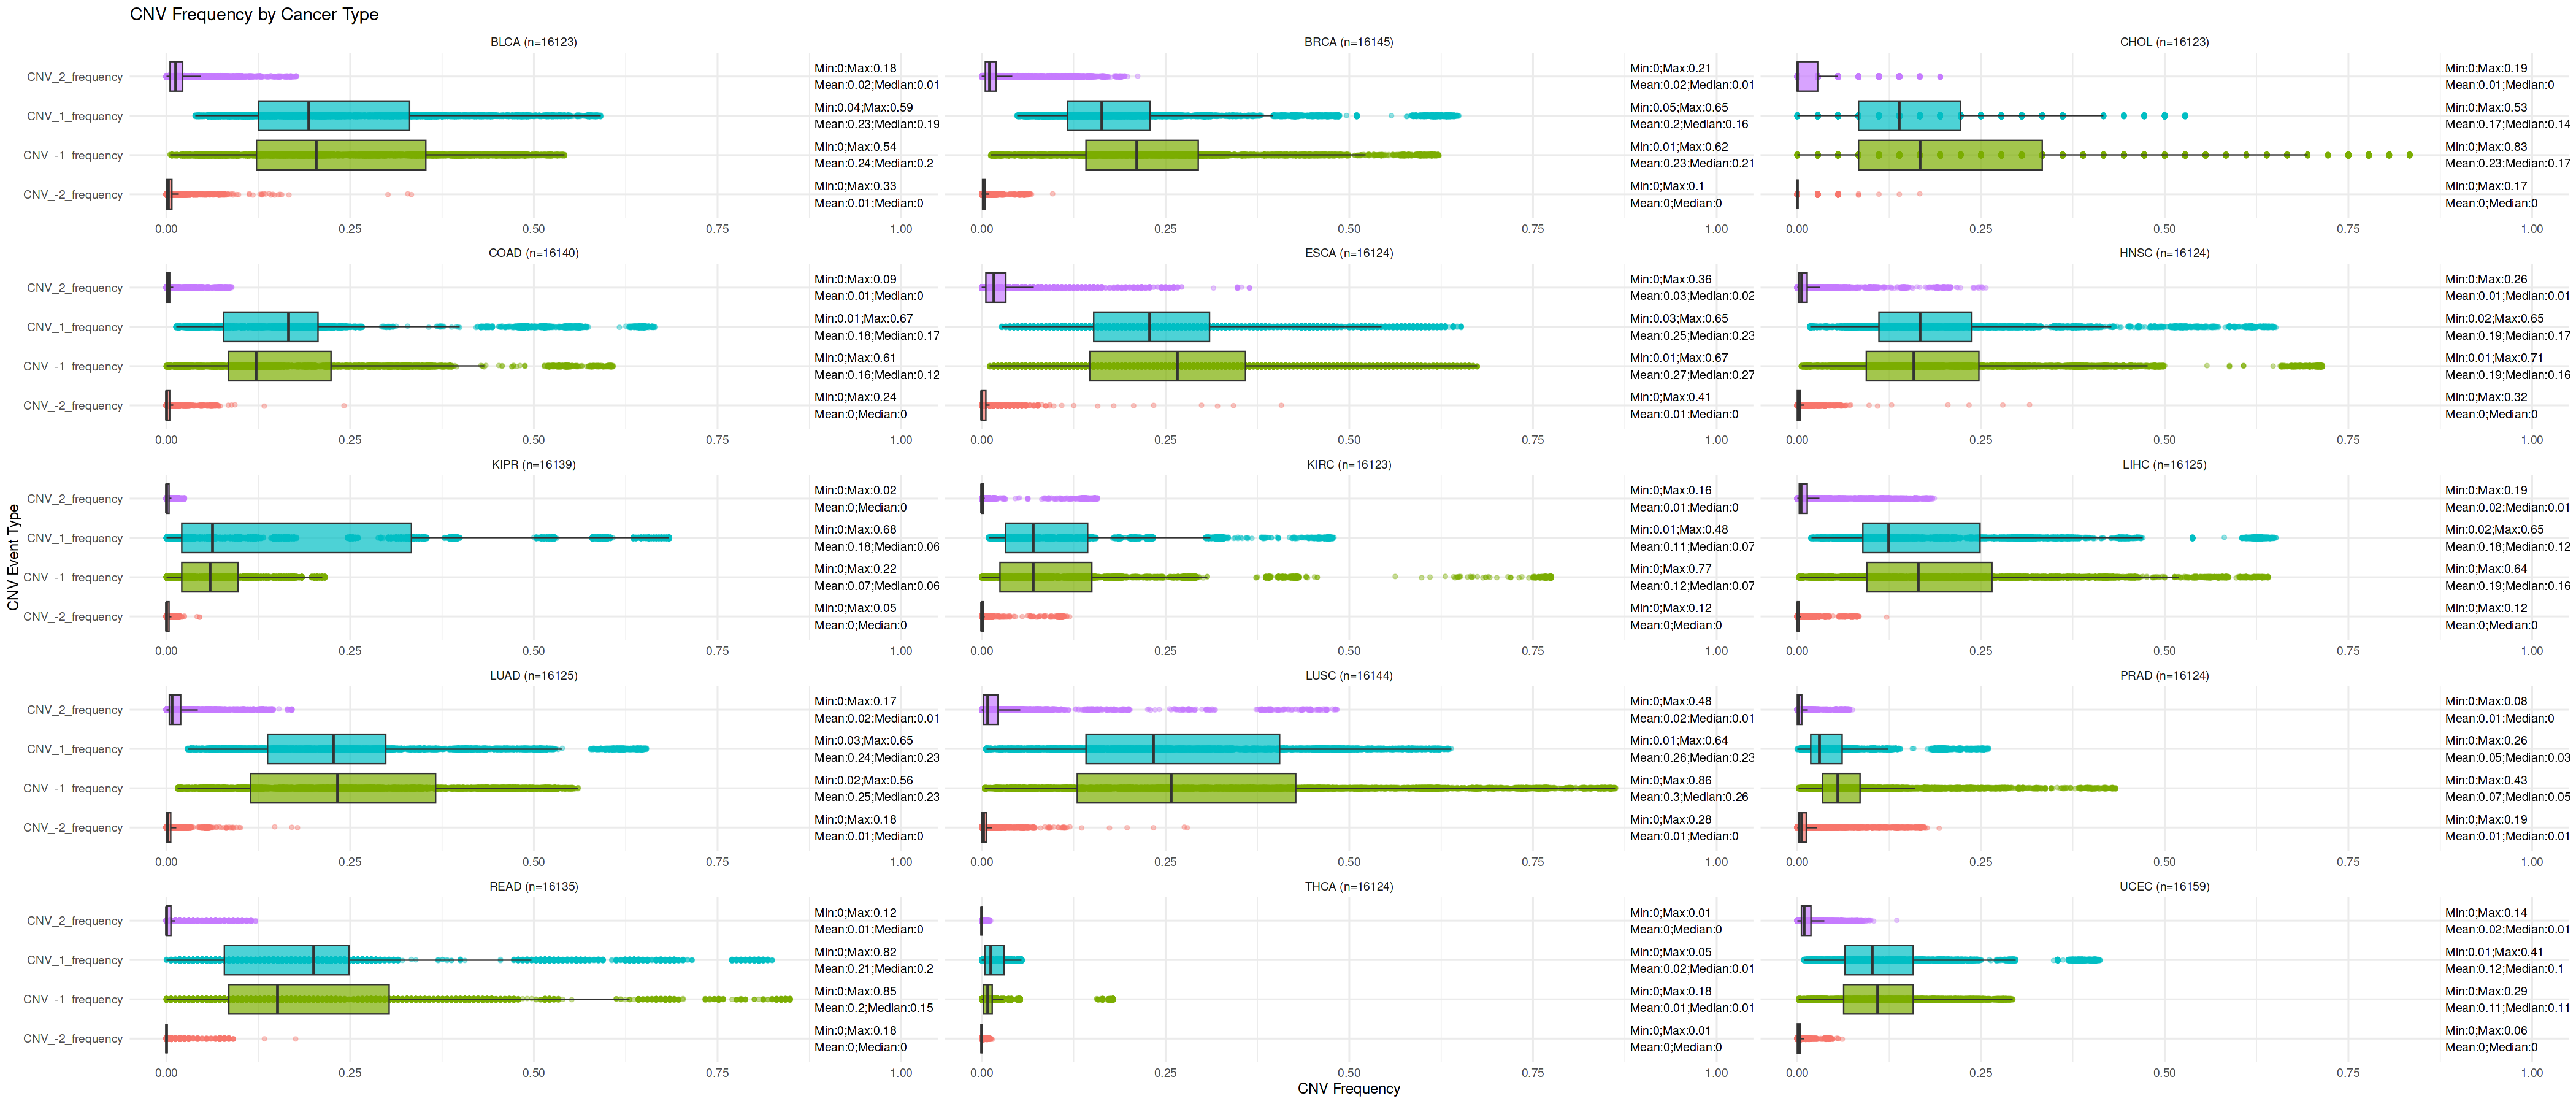

In [14]:
# ----------------------------------------------------------
# CNV frequency distribution plot by cancer type
# ----------------------------------------------------------

# Set plot size for better readability when faceting across multiple cancer types
options(repr.plot.width = 35, repr.plot.height = 15)

# Generate CNV frequency distribution plot faceted by cancer type
#   1. data_combined_cnv_tp - long-format CNV frequency data (melted)
#   2. cancer_type_stats    - precomputed summary statistics for annotation
#   3. "cancer_type"        - grouping variable for facet_wrap inside the function
plot_CNV_freq(data_combined_cnv_tp, cancer_type_stats, "cancer_type")

####  Key Inferences
- Most genes show low CNV frequencies across the genome (median near 0 for most CNV classes), which is expected since high CNV events are usually confined to specific driver regions.
- Shallow deletions (CNV_-1) and shallow gains (CNV_1) are clearly more frequent than deep deletions (CNV_-2) or amplifications (CNV_2).
- Median frequencies for CNV_-1 and CNV_1 are around 0.13–0.14.
- CNV_-2 and CNV_2 have median ~0, indicating they occur in relatively fewer genes or samples.
- Across most cancers, shallow CNVs (+1; -1) are much more common than deep events (+2; -2).
- lung adenocarcinoma (LUAD), lung squamous cell carcinoma (LUSC), head and neck squamous carcinoma (HNSC), and esophageal carcinoma (ESCA), exhibit a high burden of shallow CNV events (CNV 1; -1), with long-tailed distributions and maximum frequencies often exceeding 0.8. This pattern reflects pervasive chromosomal instability and is consistent with known focal amplifications
- Thyroid carcinoma (THCA) particularly is seen CNV-poor, with narrow CNV frequency distributions centered near zero across all event classes, indicating overall genomic stability.

## Distribution of methylation and expression data 

In [15]:
# -------------------------------------------------------------------------
# Summary statistics and normalization for Methylation & Expression logFC
# -------------------------------------------------------------------------

# Compute summary statistics for methylation |logFC| at pan-cancer level
met_logfc_stats1 <- data_combined[, summary_stats(`Me_|logFC|`), by = `pan-cancer`]
met_logfc_stats1

# Compute summary statistics for methylation |logFC| at cancer-type level
met_logfc_stats2 <- data_combined[, summary_stats(`Me_|logFC|`), by = `cancer_type`]
met_logfc_stats2

pan-cancer Min. 1st Qu. Median Mean       3rd Qu.    Max.     
1 pan-cancer 0    0       0      0.02854656 0.03070278 0.5868495

cancer_type Min. 1st Qu.     Median      Mean        3rd Qu.     Max.     
1  BLCA        0    0.000000000 0.007118273 0.040671823 0.055955665 0.4593545
2  BRCA        0    0.000000000 0.008292502 0.033695439 0.045261170 0.4108302
3  CHOL        0    0.000000000 0.000000000 0.017704562 0.000000000 0.4727051
4  COAD        0    0.000000000 0.000000000 0.037481441 0.044159698 0.5310841
5  ESCA        0    0.000000000 0.000000000 0.017746866 0.000000000 0.3755964
6  HNSC        0    0.000000000 0.004442591 0.033580157 0.042964304 0.4292052
7  KIRC        0    0.001623742 0.007094240 0.023882259 0.030932292 0.3693805
8  KIPR        0    0.000000000 0.000000000 0.018106053 0.021740037 0.4072290
9  LIHC        0    0.000000000 0.005814013 0.039142735 0.050485105 0.4217364
10 LUAD        0    0.000000000 0.000000000 0.025461025 0.034317051 0.3462652
11 LUSC        0    0.000000000 0.007434721 0.033581632 0.043649377 0.4178095
12 PRAD        0    0.000000000 0.007145854 0.030259662 0.036848700 0.4132384
13 READ        0    0.000000000 0.000000000 0.028621296 0.011463799 0.5868495
14 THCA        0    0.000000000 0.000000000 0.007729838 0.003716138 0.3742780
15 UCEC        0    0.000000000 0.006138790 0.040494802 0.049930265 0.5218573

In [16]:
# Compute summary statistics for expression |logFC| at pan-cancer level
de_logfc_stats1 <- data_combined[, summary_stats(`De_|logFC|`), by = `pan-cancer`]
de_logfc_stats1

# Compute summary statistics for expression |logFC| at cancer-type level
de_logfc_stats2 <- data_combined[, summary_stats(`De_|logFC|`), by = `cancer_type`]
de_logfc_stats2

pan-cancer Min. 1st Qu. Median Mean      3rd Qu.  Max.    
1 pan-cancer 0    0       0      0.4516004 0.634168 10.63852

cancer_type Min. 1st Qu. Median    Mean      3rd Qu.   Max.     
1  BLCA        0    0       0.0000000 0.3913253 0.5931410  7.731962
2  BRCA        0    0       0.0000000 0.2742463 0.0000000  8.063413
3  CHOL        0    0       0.0000000 0.7620285 1.1191090 10.638525
4  COAD        0    0       0.2522137 0.4856045 0.7046419  9.577344
5  ESCA        0    0       0.0000000 0.2734914 0.0000000  6.333169
6  HNSC        0    0       0.0000000 0.3913959 0.5526760  7.418274
7  KIRC        0    0       0.2465658 0.5042768 0.6964008  8.251435
8  KIPR        0    0       0.0000000 0.4403613 0.6285276  7.348955
9  LIHC        0    0       0.0000000 0.3918963 0.5879239  9.258027
10 LUAD        0    0       0.2659863 0.5055107 0.6902689  9.015783
11 LUSC        0    0       0.3824237 0.7059748 0.9514682  9.900193
12 PRAD        0    0       0.1346184 0.3037422 0.4381995  6.801234
13 READ        0    0       0.0000000 0.4566991 0.7335049 10.104362
14 THCA        0    0       0.1254958 0.3268538 0.4043584  8.645205
15 UCEC        0    0       0.2748594 0.5602705 0.8197653  7.625264

In [17]:
# -------------------------------------------
# Z-score normalization of logFC values
# -------------------------------------------

# Standardize methylation logFC values (zero mean, unit variance)
data_combined[, Me_logFC_z := (`Me_|logFC|` - mean(`Me_|logFC|`, na.rm = TRUE)) / 
                                   sd(`Me_|logFC|`, na.rm = TRUE)]

# Standardize expression logFC values (zero mean, unit variance)
data_combined[, De_logFC_z := (`De_|logFC|` - mean(`De_|logFC|`, na.rm = TRUE)) / 
                                   sd(`De_|logFC|`, na.rm = TRUE)]


# -------------------------------------------
# Summary statistics after normalization
# -------------------------------------------

# Compute summary statistics for methylation z-scores at cancer-type level
met_logfc_z_stats <- data_combined[, summary_stats(Me_logFC_z), by = `cancer_type`]
met_logfc_z_stats

# Compute summary statistics for expression z-scores at cancer-type level
de_logfc_z_stats <- data_combined[, summary_stats(De_logFC_z), by = `cancer_type`]
de_logfc_z_stats


cancer_type Min.       1st Qu.    Median     Mean         3rd Qu.    
1  BLCA        -0.5126764 -0.5126764 -0.3848372  0.217761395  0.49224862
2  BRCA        -0.5126764 -0.5126764 -0.3637488  0.092470355  0.30018289
3  CHOL        -0.5126764 -0.5126764 -0.5126764 -0.194714733 -0.51267642
4  COAD        -0.5126764 -0.5126764 -0.5126764  0.160464331  0.28040121
5  ESCA        -0.5126764 -0.5126764 -0.5126764 -0.193954979 -0.51267642
6  HNSC        -0.5126764 -0.5126764 -0.4328906  0.090399966  0.25893275
7  KIRC        -0.5126764 -0.4835151 -0.3852688 -0.083767563  0.04284616
8  KIPR        -0.5126764 -0.5126764 -0.5126764 -0.187504239 -0.12224039
9  LIHC        -0.5126764 -0.5126764 -0.4082608  0.190300031  0.39400115
10 LUAD        -0.5126764 -0.5126764 -0.5126764 -0.055414018  0.10363408
11 LUSC        -0.5126764 -0.5126764 -0.3791540  0.090426464  0.27123619
12 PRAD        -0.5126764 -0.5126764 -0.3843418  0.030766185  0.14910074
13 READ        -0.5126764 -0.5126764 -0.5126764  0.001342253 -0.30679453
14 THCA        -0.5126764 -0.5126764 -0.5126764 -0.373853885 -0.44593715
15 UCEC        -0.5126764 -0.5126764 -0.4024280  0.214582207  0.38403660
   Max.     
1   7.737012
2   6.865550
3   7.976780
4   9.025227
5   6.232774
6   7.195552
7   6.121141
8   6.800875
9   7.061418
10  5.706007
11  6.990893
12  6.908799
13 10.026735
14  6.209098
15  8.859520

cancer_type Min.       1st Qu.    Median     Mean         3rd Qu.    
1  BLCA        -0.5762614 -0.5762614 -0.5762614 -0.076913585  0.18061186
2  BRCA        -0.5762614 -0.5762614 -0.5762614 -0.226311316 -0.57626136
3  CHOL        -0.5762614 -0.5762614 -0.5762614  0.396119519  0.85176952
4  COAD        -0.5762614 -0.5762614 -0.2544259  0.043390749  0.32289177
5  ESCA        -0.5762614 -0.5762614 -0.5762614 -0.227274703 -0.57626136
6  HNSC        -0.5762614 -0.5762614 -0.5762614 -0.076823483  0.12897688
7  KIRC        -0.5762614 -0.5762614 -0.2616329  0.067217338  0.31237577
8  KIPR        -0.5762614 -0.5762614 -0.5762614 -0.014341514  0.22576675
9  LIHC        -0.5762614 -0.5762614 -0.5762614 -0.076184886  0.17395459
10 LUAD        -0.5762614 -0.5762614 -0.2368514  0.068791918  0.30455128
11 LUSC        -0.5762614 -0.5762614 -0.0882724  0.324592673  0.63785269
12 PRAD        -0.5762614 -0.5762614 -0.4044826 -0.188673335 -0.01710005
13 READ        -0.5762614 -0.5762614 -0.5762614  0.006506221  0.35972227
14 THCA        -0.5762614 -0.5762614 -0.4161234 -0.159181892 -0.06028275
15 UCEC        -0.5762614 -0.5762614 -0.2255290  0.138667692  0.46979418
   Max.     
1   9.290053
2   9.712998
3  12.998950
4  11.644838
5   7.505133
6   8.889773
7   9.952922
8   8.801319
9  11.237377
10 10.928263
11 12.056808
12  8.102404
13 12.317337
14 10.455390
15  9.153901

Picking joint bandwidth of 0.0383



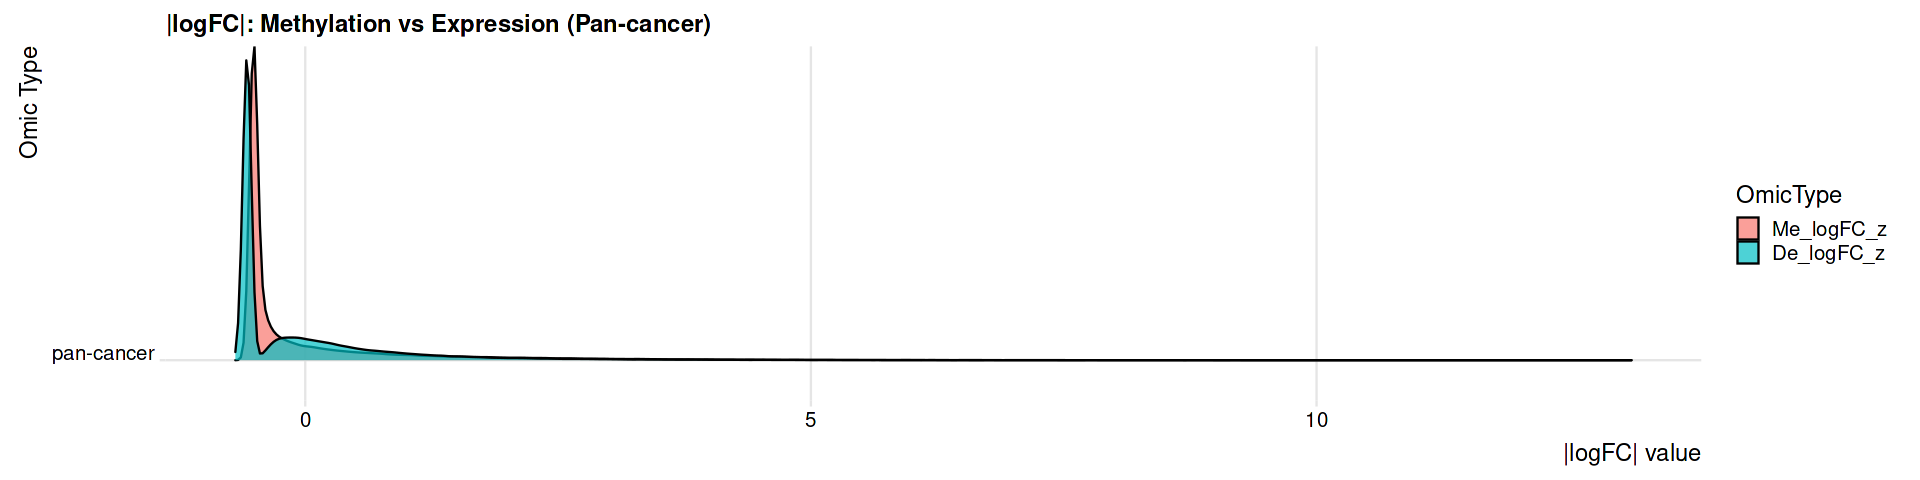

In [18]:
# ----------------------------------------------------------
# Compare distribution of |logFC| (z-scored) for Methylation and Expression
# ----------------------------------------------------------

# Reshape data from wide to long format
# - 'Me_logFC_z' and 'De_logFC_z' columns are melted into a single column 'AbsLogFC'
# - 'OmicType' column indicates whether the value comes from methylation or expression
met_exp <- melt(
  data_combined, 
  measure.vars = c("Me_logFC_z", "De_logFC_z"),
  variable.name = "OmicType", 
  value.name = "AbsLogFC"
)

# ----------------------------------------------------------
# Pan-cancer distribution plot
# ----------------------------------------------------------

# Set plot dimensions for better visualization
options(repr.plot.width = 16, repr.plot.height = 4)

# Density ridge plot comparing the distribution of methylation and expression |logFC| values
ggplot(met_exp, aes(x = AbsLogFC, y = `pan-cancer`, fill = OmicType)) +
  geom_density_ridges(alpha = 0.7, scale = 0.9) +   # visualize distributions as ridgelines
  labs(
    title = "|logFC|: Methylation vs Expression (Pan-cancer)",
    x = "|logFC| value",
    y = "Omic Type"
  ) +
  theme_minimal(base_size = 14) +                  # clean minimal theme
  theme_ridges() 

Picking joint bandwidth of 0.0793



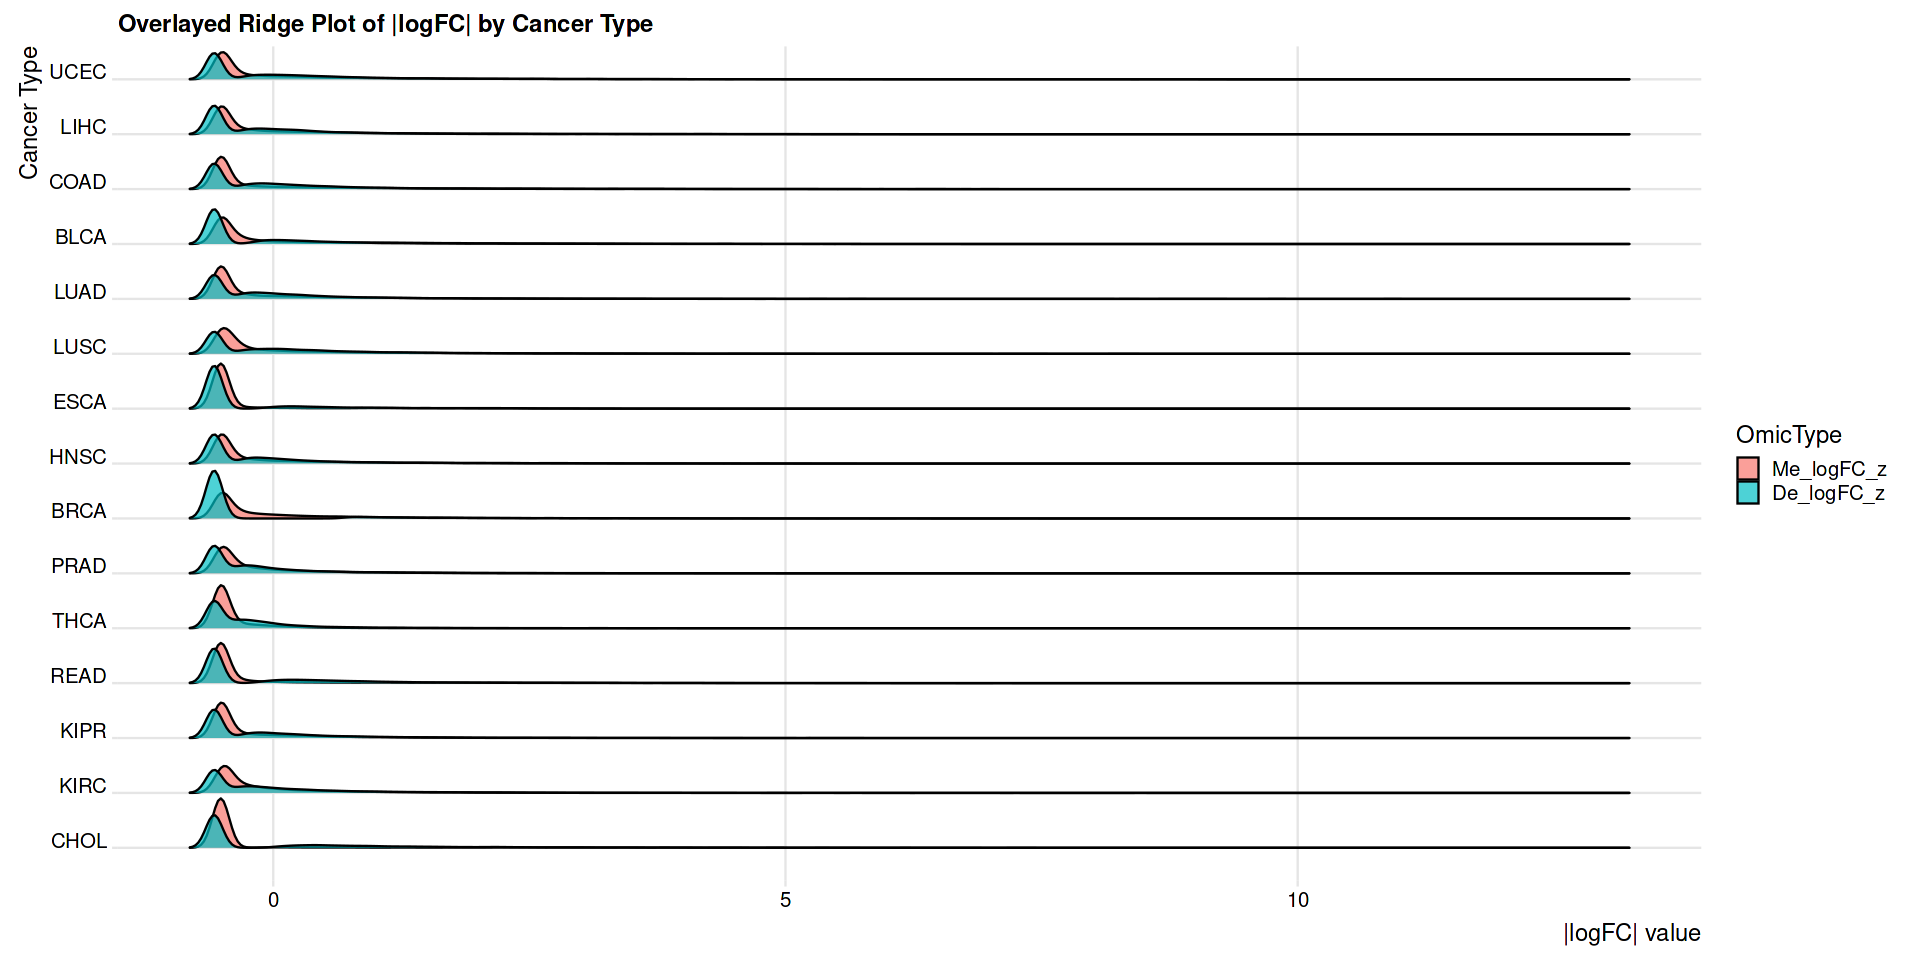

In [19]:
# ----------------------------------------------------------
# Overlayed ridge plot of |logFC| (z-scored) by cancer type
# ----------------------------------------------------------

# Set plot size to ensure clear visualization across multiple cancer types
options(repr.plot.width = 16, repr.plot.height = 8)

# Ridge plot showing the distribution of methylation and expression |logFC| values
# for each cancer type
ggplot(met_exp, aes(x = AbsLogFC, y = cancer_type, fill = OmicType)) +
  
  # Draw ridge lines for each cancer type, overlaying methylation and expression
  geom_density_ridges(alpha = 0.7, scale = 0.9) +
  
  # Add plot title and axis labels
  labs(
    title = "Overlayed Ridge Plot of |logFC| by Cancer Type",
    x = "|logFC| value",
    y = "Cancer Type"
  ) +
  theme_minimal(base_size = 14) + 
  theme_ridges() # Ridge-specific styling for clean appearance


### Key Inferences

- Z-score transformation was applied to |logFC| values to standardize distributions across omics layers, since expression and methylation logFC ranges were markedly different (expression up to ~10, methylation up to ~0.59).
- Most genes show low |logFC| values, reflected in a sharp peak near zero for both methylation and expression across cancer types.
- Expression |logFC| distributions are broader with a long right tail, indicating a subset of genes undergo large transcriptional changes.
- Methylation |logFC| values are tightly concentrated near zero, showing fewer and subtler alterations.
- Tumors such as CHOL, LUAD, LUSC, COAD, and UCEC display higher expression perturbation, whereas methylation patterns remain more consistent across cancers.
- Since only absolute |logFC| values are used, the analysis captures the magnitude of change but not its direction (up/down regulation or hyper/hypomethylation).


<a id='task2'></a>
# Task 2: CNV Analysis

**Assignment requirement:**  
- Identify top 10 genes with highest number of amplifications (CNV_2) and deletions (CNV_-2) in each cancer type.  
- Visualize CNV distributions for these genes.  
- Draw inferences in terms of CNV markers in specific cancers.


In [20]:
# ----------------------------------------------------------
# Top 10 genes with highest CNV amplifications and deletions per cancer type
# ----------------------------------------------------------

# Subset relevant CNV columns and remove rows with invalid CNV frequency values
cnv_df <- subset(
  data_combined,
  CNV_frequency != "NaN",
  select = c(
    "CNV_-2_frequency", "CNV_-1_frequency",
    "CNV_1_frequency", "CNV_2_frequency",
    "CNV_frequency", "Gene", "cancer_type", "pan-cancer"
  ))

# Identify top 10 genes with highest CNV amplifications (CNV_2_frequency) in each cancer type
#    1. Order genes within each cancer type by CNV_2_frequency in descending order
#    2. Select top 10 per group
top10_cnv_2_per_cancer <- cnv_df[rev(order(CNV_2_frequency)), .SD[1:10], by = cancer_type]

# Identify top 10 genes with highest CNV deletions (CNV_-2_frequency) in each cancer type
#    - Similar logic as above, for CNV_-2
top10_cnv_minus2_per_cancer <- cnv_df[rev(order(`CNV_-2_frequency`)), .SD[1:10], by = cancer_type]

# Combine top 10 amplified and deleted gene lists into one table for visualization
top10_cnv <- rbind(top10_cnv_2_per_cancer, top10_cnv_minus2_per_cancer)

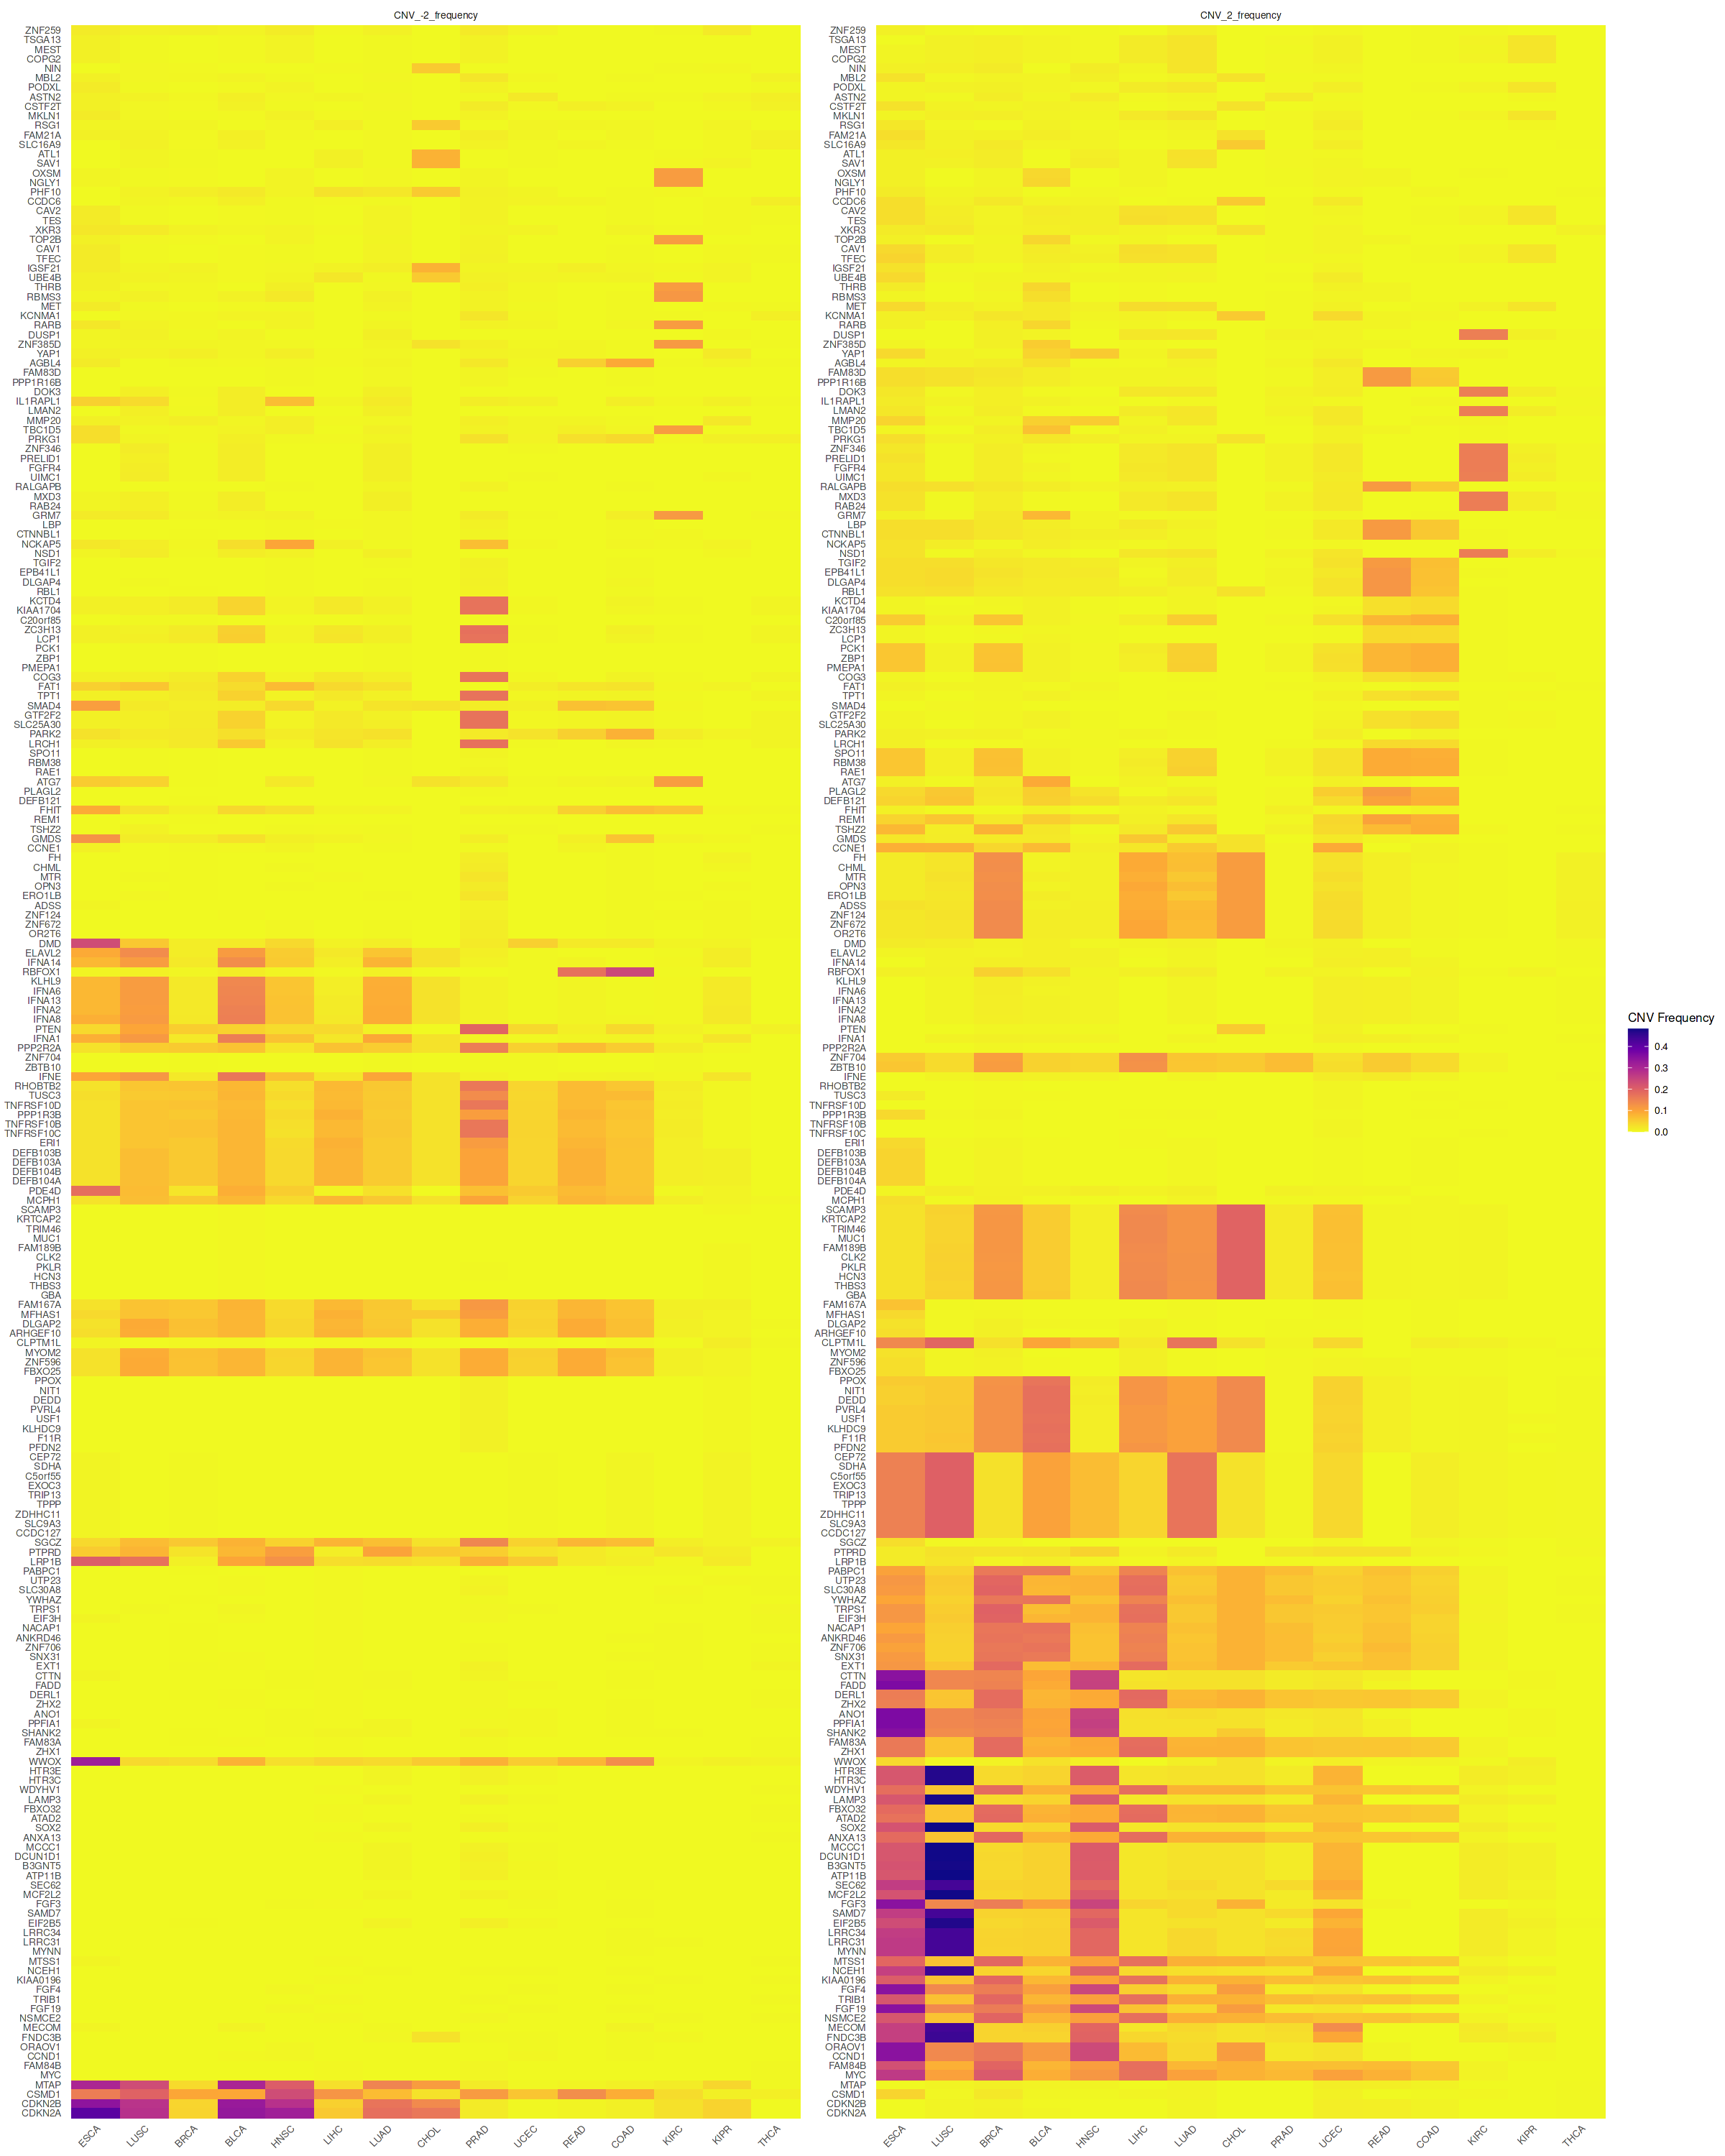

In [21]:
# ----------------------------------------------------------
# Visualize CNV frequencies for top 10 amplified/deleted genes
# ----------------------------------------------------------

# Subset the full CNV table to keep only genes present in the top 10 CNV list
# This allows us to visualize how these top CNV genes behave across *all* cancer types,
# not just the ones they were originally selected from.
top10_cnv_df_toplot <- subset(cnv_df, Gene %in% top10_cnv$Gene)

# Reshape data from wide to long format
#   1. 'CNV_-2_frequency' and 'CNV_2_frequency' will be melted into a single 'variable' column
#   2. This is necessary for faceting amplification and deletion in the heatmap
top10_cnv_df <- melt(
  top10_cnv_df_toplot,
  id.vars = c("cancer_type", "pan-cancer", "Gene")
)

# Filter only amplification and deletion frequency columns
top10_cnv_df <- subset(
  top10_cnv_df,
  variable %in% c("CNV_-2_frequency", "CNV_2_frequency")
)

# ----------------------------------------------------------
# Determine gene and cancer type order based on mean CNV frequency
# This ensures the heatmap is sorted by most frequently altered genes and cancer types
# ----------------------------------------------------------

# Compute mean CNV frequency for each gene and sort in descending order
gene_order <- top10_cnv_df[, .(mean_freq = mean(value, na.rm = TRUE)), 
                           by = Gene][rev(order(mean_freq)), Gene]

# Compute mean CNV frequency for each cancer type and sort
cancer_order <- top10_cnv_df[, .(mean_freq = mean(value, na.rm = TRUE)), 
                             by = cancer_type][rev(order(mean_freq)), cancer_type]

# Set factor levels to enforce ordering in the ggplot heatmap
top10_cnv_df[, Gene := factor(Gene, levels = gene_order)]
top10_cnv_df[, cancer_type := factor(cancer_type, levels = cancer_order)]

# ----------------------------------------------------------
# Heatmap visualization of CNV frequencies for top 10 genes across cancers
# ----------------------------------------------------------
options(repr.plot.width = 20, repr.plot.height = 25)

ggplot(top10_cnv_df, aes(x = cancer_type, y = Gene, fill = value)) +
  geom_tile() +  # draw tiles representing CNV frequencies
  facet_wrap(~ variable, scales = "free_y") +  # separate amplification and deletion panels
  scale_fill_viridis_c(option = "plasma", direction = -1) +  # color scale
  theme_minimal(base_size = 10) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title = element_blank(),
    panel.grid = element_blank()
  ) +
  labs(fill = "CNV Frequency")


In [22]:
#----------------------------------------------------------
# Identifying common and unique top 10 CNV amplified and deleted genes across cancer types
# ----------------------------------------------------------

# Run the custom function for CNV amplifications (CNV_2)
# - Returns both the binary presence matrix and the list of unique genes for downstream analysis
amp_results <- create_upset_and_get_unique_genes(
  top10_cnv_df,
  cnv_var = "CNV_2_frequency",
  combo = c("UCEC", "BRCA")
)

# Run the custom function for CNV deletions (CNV_-2)
del_results <- create_upset_and_get_unique_genes(
  top10_cnv_df,
  cnv_var = "CNV_-2_frequency",
  combo = c("UCEC", "LUAD", "PRAD")
)

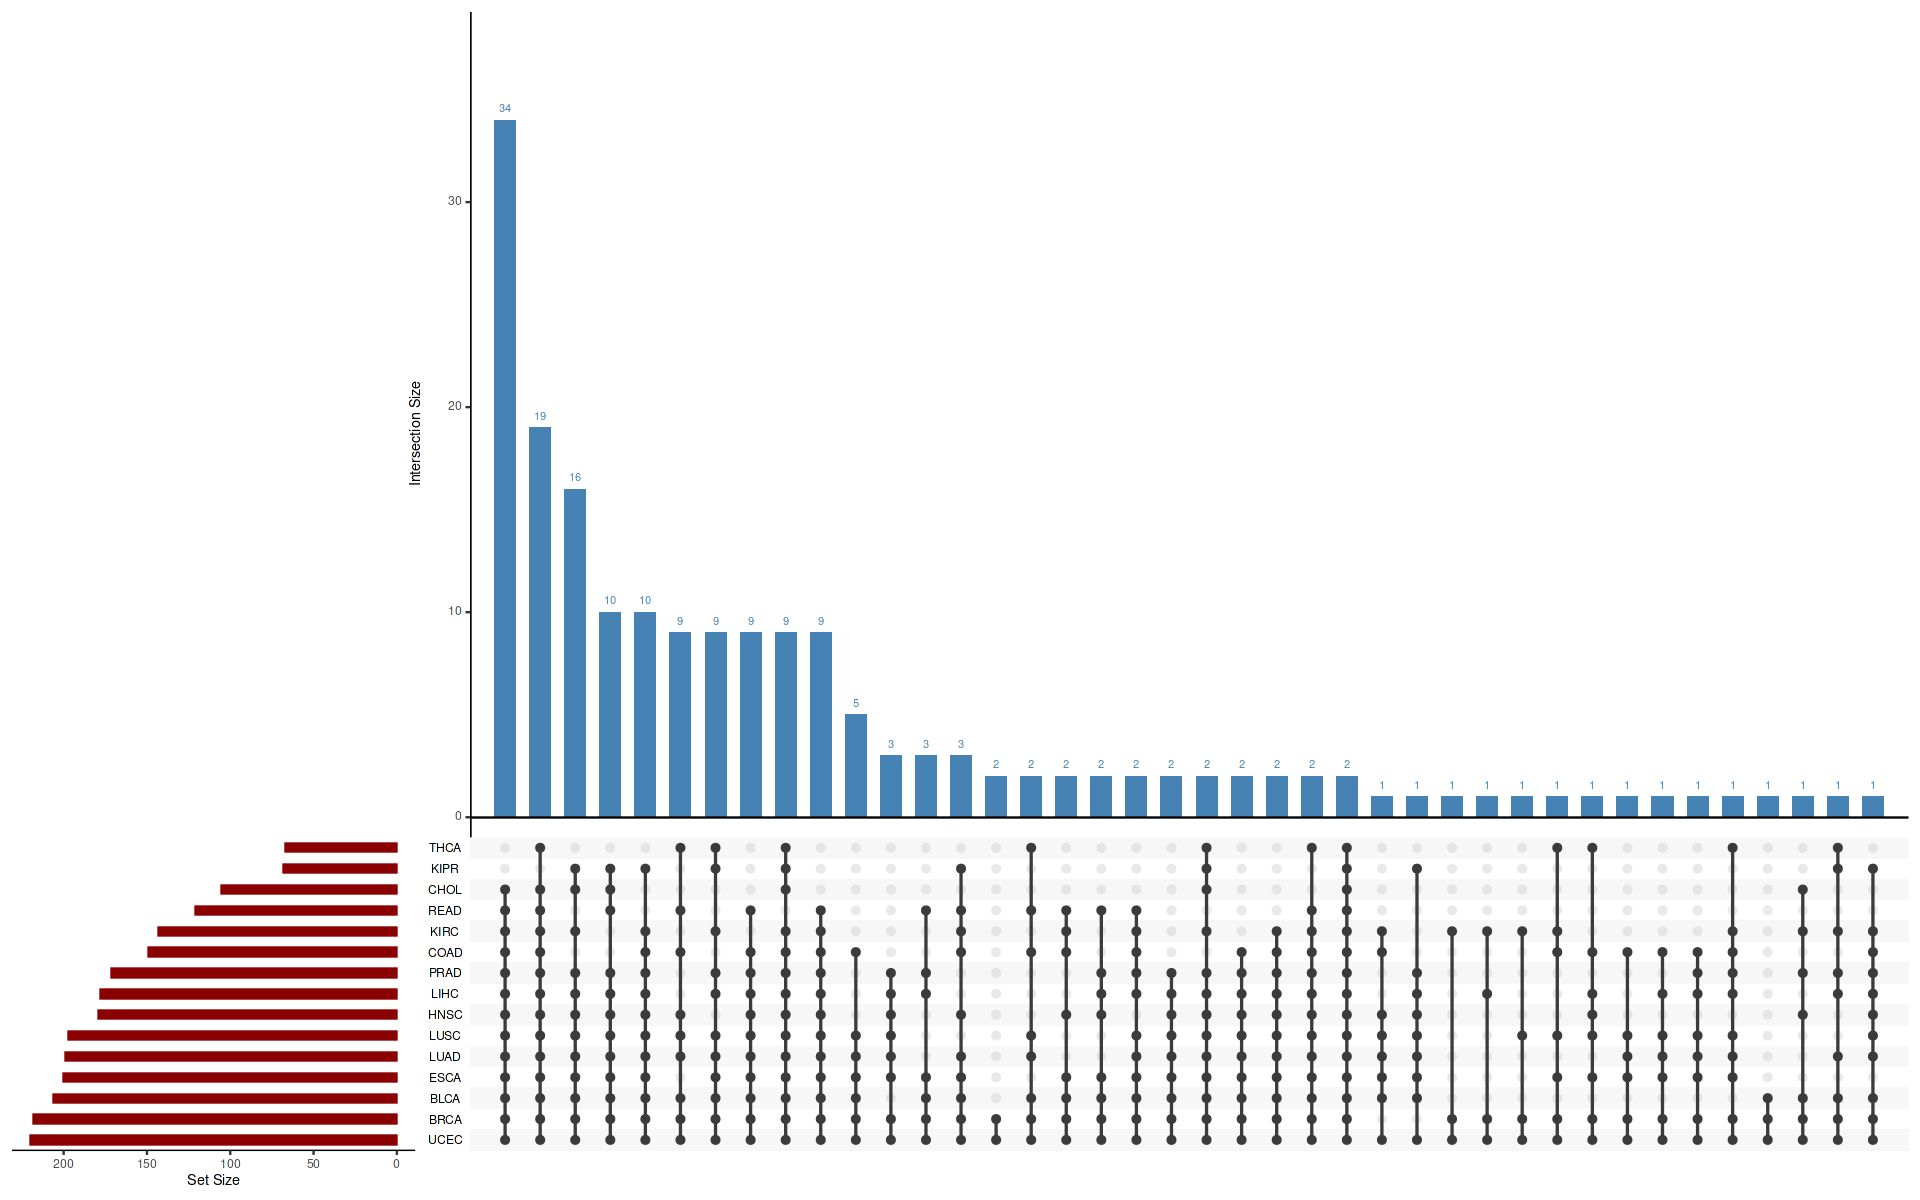

In [23]:
# Generates an UpSet plot showing intersections of top amplified genes across "UCEC" and "BRCA" cancer types
options(repr.plot.width = 16, repr.plot.height = 10)
amp_results$plot

In [24]:
# Extract genes uniquely amplified in the combination of UCEC and BRCA
amp_results$unique_genes

[1] "TNFRSF10B" "RHOBTB2"

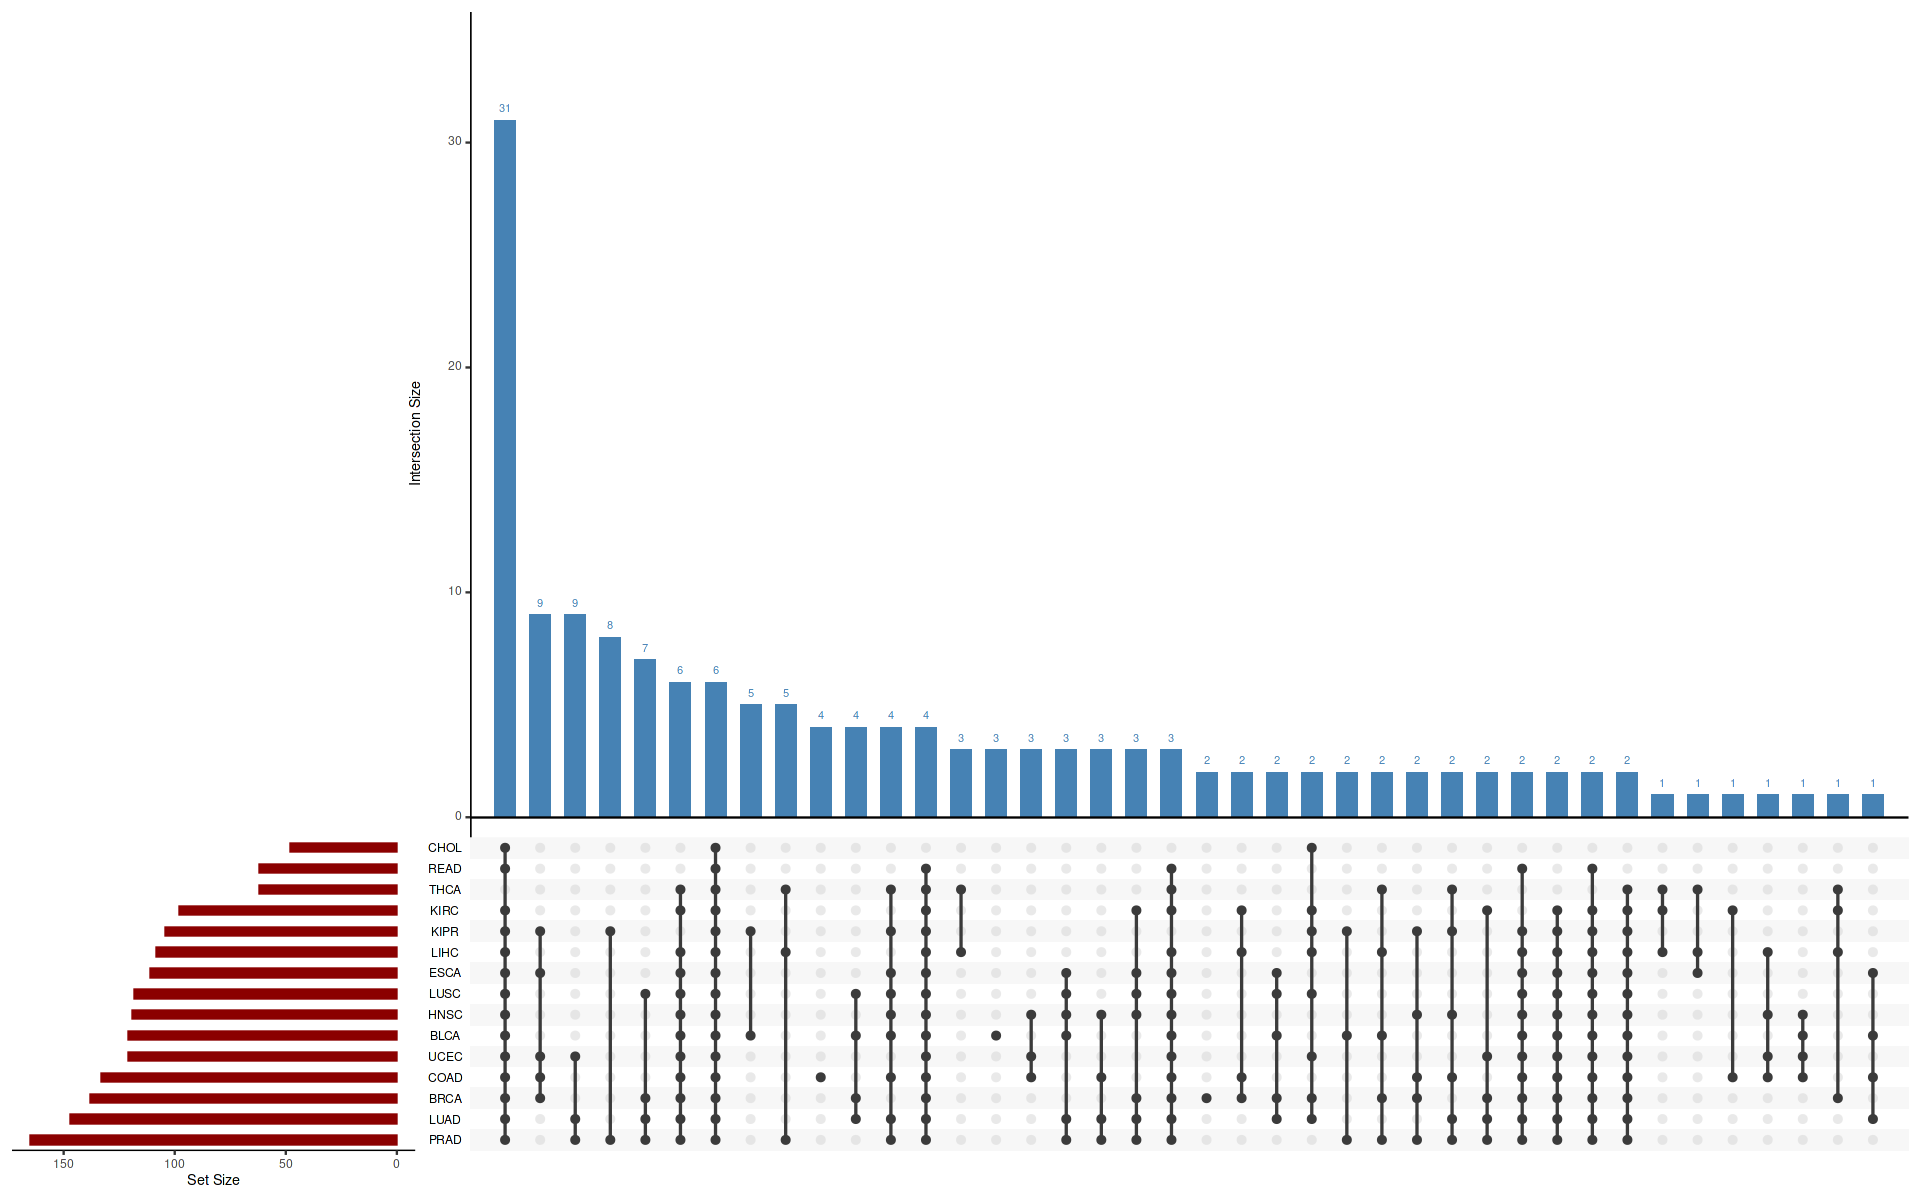

In [25]:
# Generates an UpSet plot showing intersections of top deleted genes across "UCEC", "LUAD" and "PRAD" cancer types
options(repr.plot.width = 16, repr.plot.height = 10)
del_results$plot

In [26]:
# Extract genes uniquely deleted across "UCEC", "LUAD" and "PRAD" cancer types combined
del_results$unique_genes

[1] "MCF2L2"  "ATP11B"  "B3GNT5"  "DCUN1D1" "MCCC1"   "SOX2"    "LAMP3"  
[8] "HTR3C"   "HTR3E"

### Key Inferences

- Top 10 most frequently amplified (CNV_2) and deleted (CNV_-2) genes were identified for each cancer type, and their frequencies were visualized in a heatmap to highlight CNV distribution patterns across cancers.
- The heatmap shows stronger and more widespread amplification signals, with higher CNV_2 frequencies observed in ESCA, LUSC, BRCA, and HNSC, indicating these are CNV-rich tumor types.
- Amplified genes such as SOX2 and DCUN1D1—known 3q26 oncogenic drivers in squamous cancers—show particularly high amplification frequencies in these tumor types.
- Deletion signals are more focal but notable in several cancers, with CDKN2A and CDKN2B showing higher deletion frequencies in ESCA, LUSC, BLCA, and HNSC, consistent with their role as common tumor suppressor loss events.
- UpSet analysis revealed large intersections for both amplification (31 genes) and deletion (34 genes), indicating pan-cancer CNV hotspots shared across multiple tumor types.
- Unique amplification signatures were detected, including TNFRSF10B and RHOBTB2 in "UCEC-BRCA"; both genes have been implicated in apoptosis regulation and tumor progression, highlighting potential subtype-specific CNV events.
- A distinct deletion signature involving 9 genes uniquely in UCEC, LUAD, and PRAD; Likely these collective impact of tumor suppression, cellular trafficking, and neurotransmitter signaling. The shared CNV loss across these different cancers suggests a fundamental, and potentially common, mechanism of cancer progression. 


<a id='task3'></a>
# Task 3: Multi-omics Integration

**Assignment requirement:**  
- Correlate CNV with differential expression.  
- Correlate methylation with differential expression.  
- Highlight genes with significant changes in both.


In [27]:
#---------------------------------------------------------------------------------
# Correlation between CNV burden and gene expression (pan-cancer)
#---------------------------------------------------------------------------------

# Calculate CNV burden as: amplifications (CNV_1 + CNV_2) minus deletions (CNV_-1 + CNV_-2)
data_combined[, CNV_burden := (CNV_1 + CNV_2) - (`CNV_-1` + `CNV_-2`)]

#---------------------------------------------------------------------------------
# Compute Spearman correlation
# Spearman is preferred due to the right-skewed distribution of CNV burden.
#---------------------------------------------------------------------------------
corr_results_cnv_exp_pan_cancer <- 
compute_groupwise_spearman(data_combined, "CNV_burden", "De_logFC_z", "pan-cancer")
corr_results_cnv_exp_pan_cancer

pan-cancer corr      pval         label                   
1 pan-cancer 0.0410293 1.170279e-90 rho = 0.04\np = 1.17e-90

`geom_smooth()` using formula = 'y ~ x'


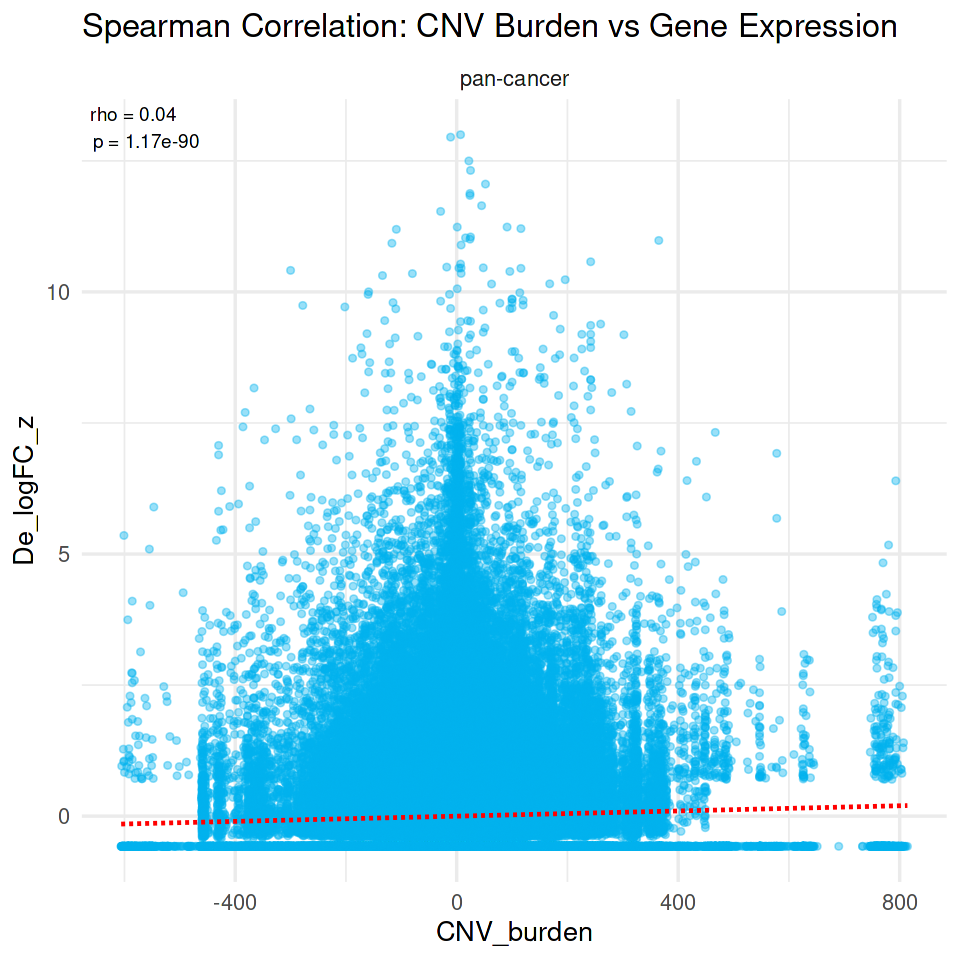

In [28]:
#---------------------------------------------------------------------------------
# Visualization: Scatter plot of CNV burden vs gene expression
#---------------------------------------------------------------------------------
# Set plot dimensions
options(repr.plot.width = 8, repr.plot.height = 8)
plot_correlation_scatter(data_combined, "CNV_burden", "De_logFC_z", corr_results_cnv_exp_pan_cancer, 
                         "Spearman Correlation: CNV Burden vs Gene Expression", "pan-cancer")

In [29]:
#---------------------------------------------------------------------------------
# Compute Spearman correlation
# Spearman is preferred due to the right-skewed distribution of CNV burden.
#---------------------------------------------------------------------------------
corr_results_cnv_exp_cancer_type <- 
compute_groupwise_spearman(data_combined, "CNV_burden", "De_logFC_z", "cancer_type")
corr_results_cnv_exp_cancer_type


cancer_type corr         pval         label                    
1  BLCA         0.036256279 4.127676e-06 rho = 0.04\np = 4.13e-06 
2  BRCA         0.042763672 5.456787e-08 rho = 0.04\np = 5.46e-08 
3  CHOL         0.030393955 1.134303e-04 rho = 0.03\np = 1.13e-04 
4  COAD         0.047599908 1.446568e-09 rho = 0.05\np = 1.45e-09 
5  ESCA         0.002250273 7.750937e-01 rho = 0\np = 7.75e-01    
6  HNSC         0.031645057 5.844710e-05 rho = 0.03\np = 5.84e-05 
7  KIRC         0.016712113 3.383546e-02 rho = 0.02\np = 3.38e-02 
8  KIPR         0.040503382 2.643508e-07 rho = 0.04\np = 2.64e-07 
9  LIHC         0.040652770 2.417330e-07 rho = 0.04\np = 2.42e-07 
10 LUAD         0.068144066 4.610330e-18 rho = 0.07\np = 4.61e-18 
11 LUSC         0.066462442 2.830674e-17 rho = 0.07\np = 2.83e-17 
12 PRAD        -0.007938155 3.134894e-01 rho = -0.01\np = 3.13e-01
13 READ         0.040538607 2.589920e-07 rho = 0.04\np = 2.59e-07 
14 THCA         0.004476713 5.697544e-01 rho = 0\np = 5.70e-01    
15 UCEC         0.009321300 2.360809e-01 rho = 0.01\np = 2.36e-01

`geom_smooth()` using formula = 'y ~ x'


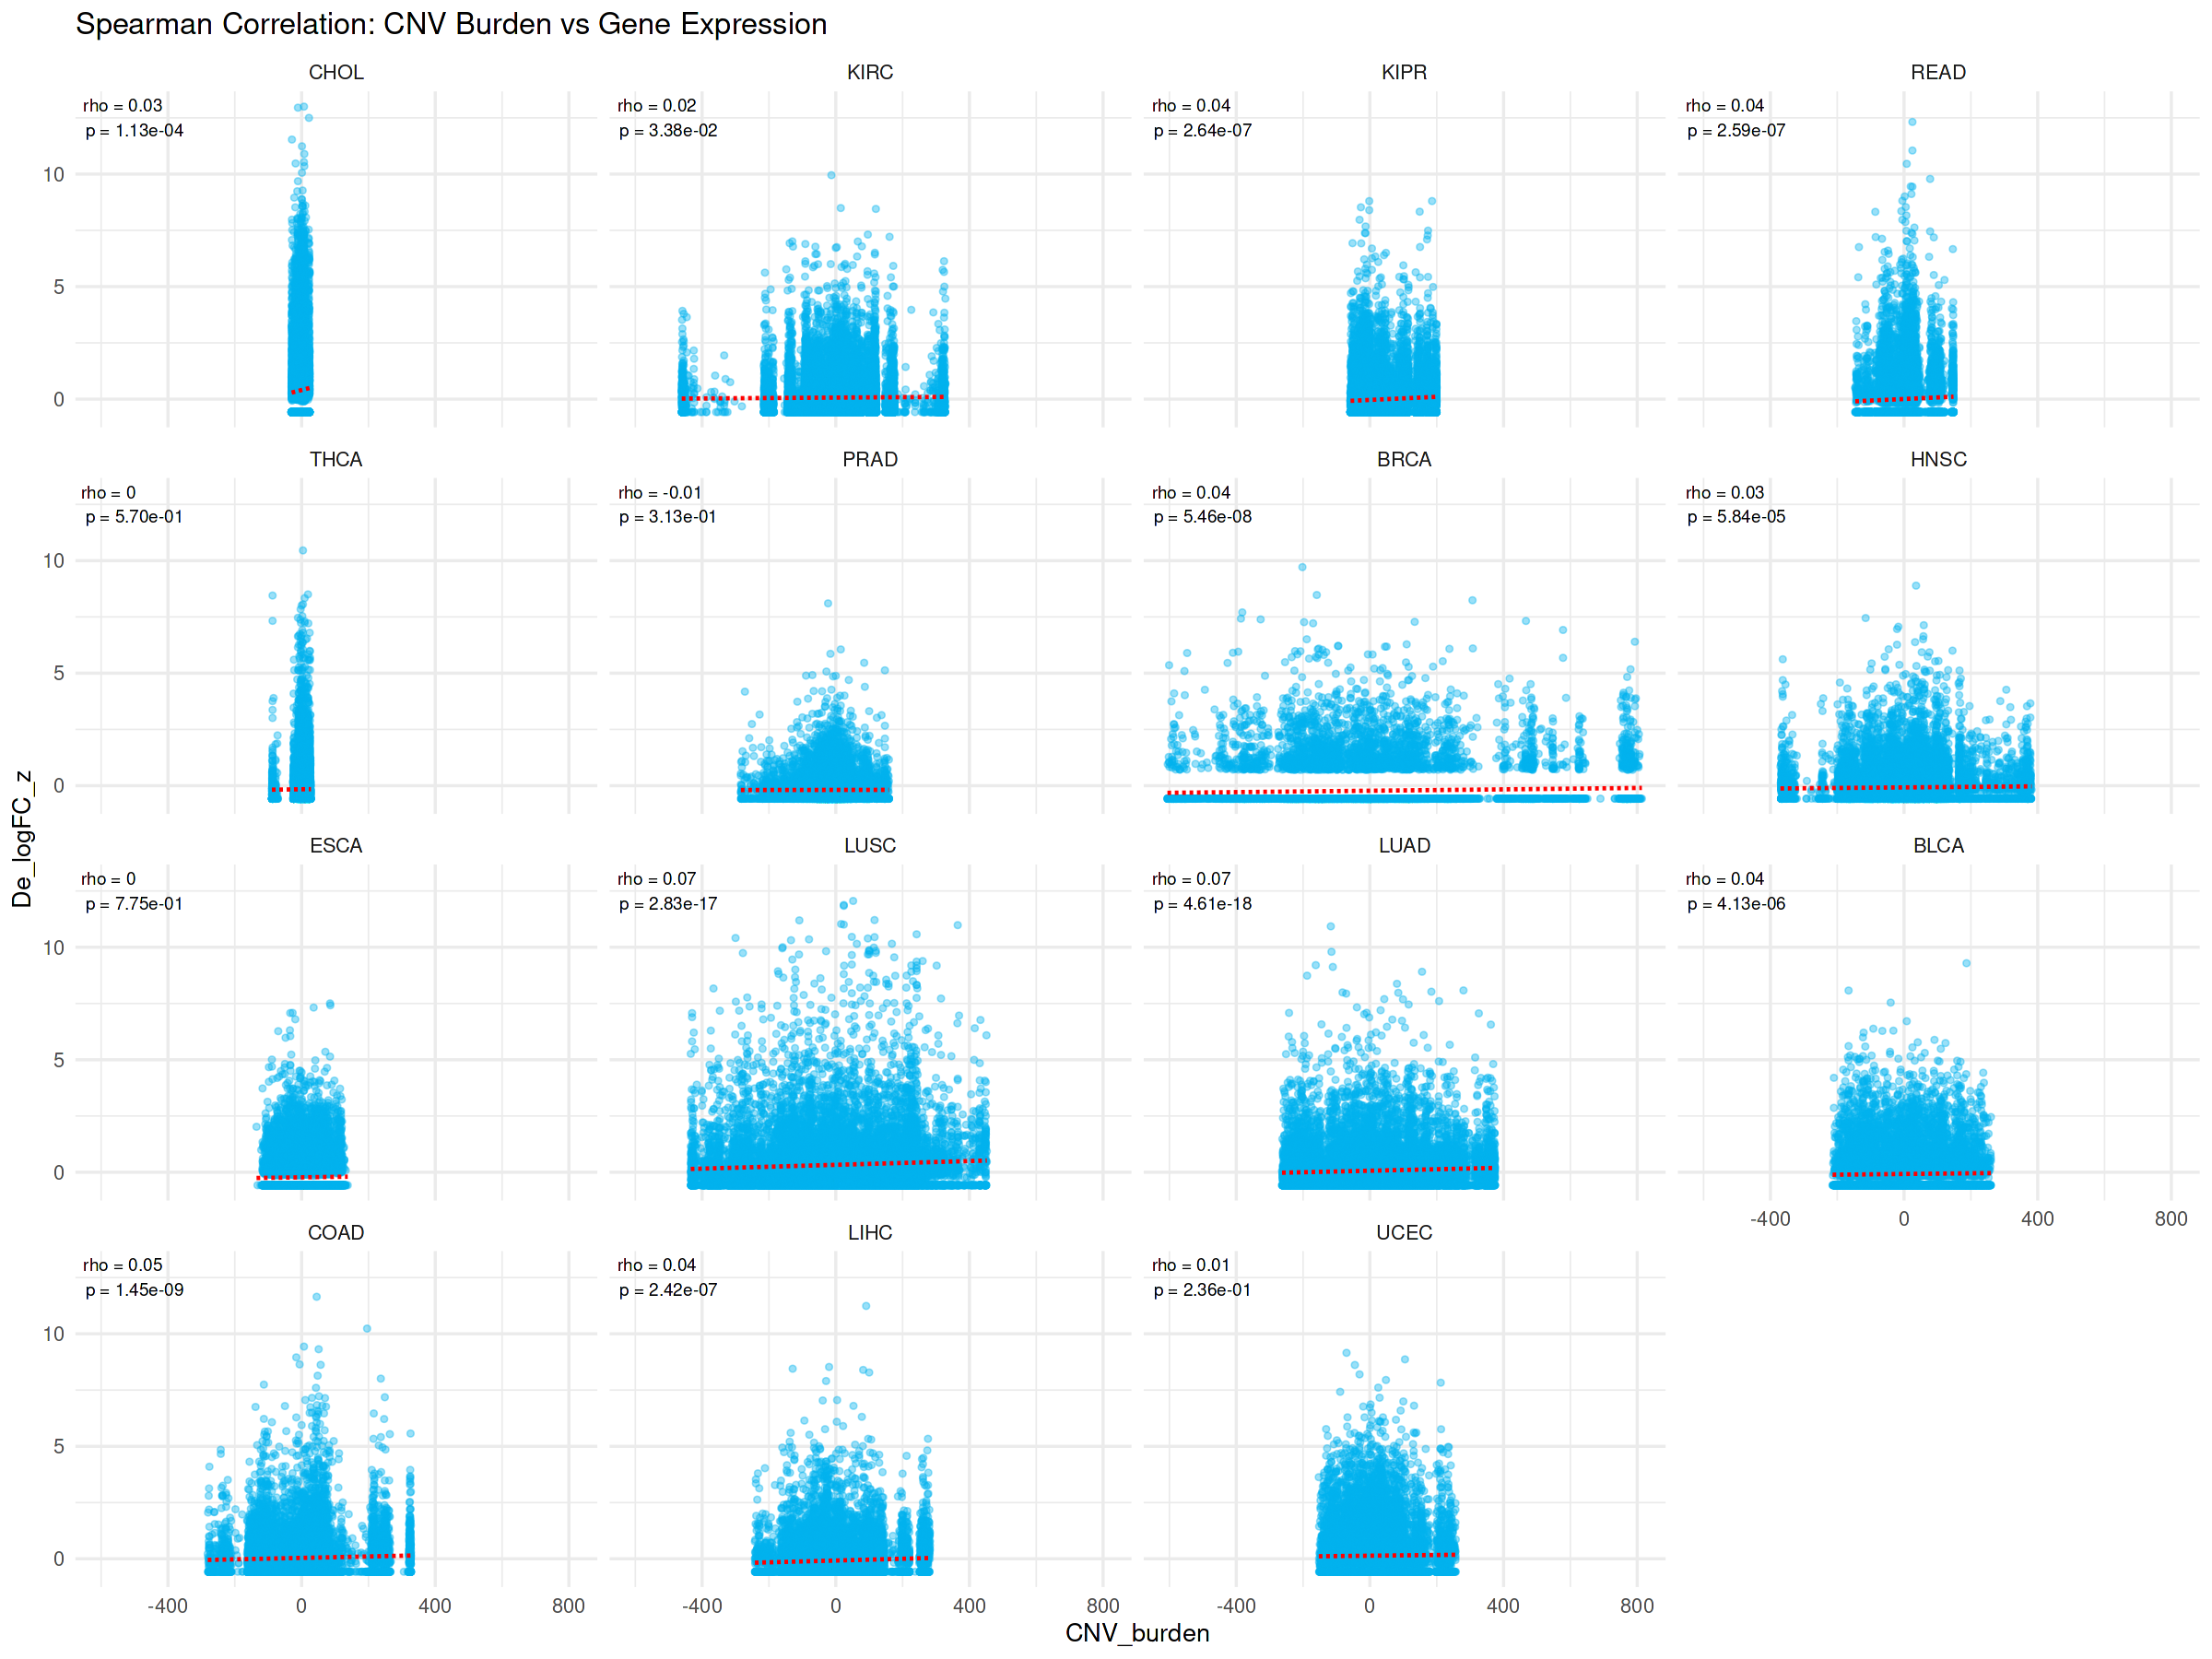

In [30]:
#---------------------------------------------------------------------------------
# Visualization: Scatterplot of CNV burden vs expression per cancer type
#---------------------------------------------------------------------------------

# Set figure size
options(repr.plot.width = 20, repr.plot.height = 15)
plot_correlation_scatter(data_combined, "CNV_burden", "De_logFC_z", corr_results_cnv_exp_cancer_type, 
                         "Spearman Correlation: CNV Burden vs Gene Expression", "cancer_type")

In [31]:
#---------------------------------------------------------------------------------
# Correlation between methylation and gene expression (pan-cancer)
#---------------------------------------------------------------------------------

corr_results_met_exp_pan_cancer <- 
compute_groupwise_spearman(data_combined, "Me_logFC_z", "De_logFC_z", "pan-cancer")
corr_results_met_exp_pan_cancer

pan-cancer corr       pval         label                    
1 pan-cancer -0.0265716 4.690128e-39 rho = -0.03\np = 4.69e-39

`geom_smooth()` using formula = 'y ~ x'


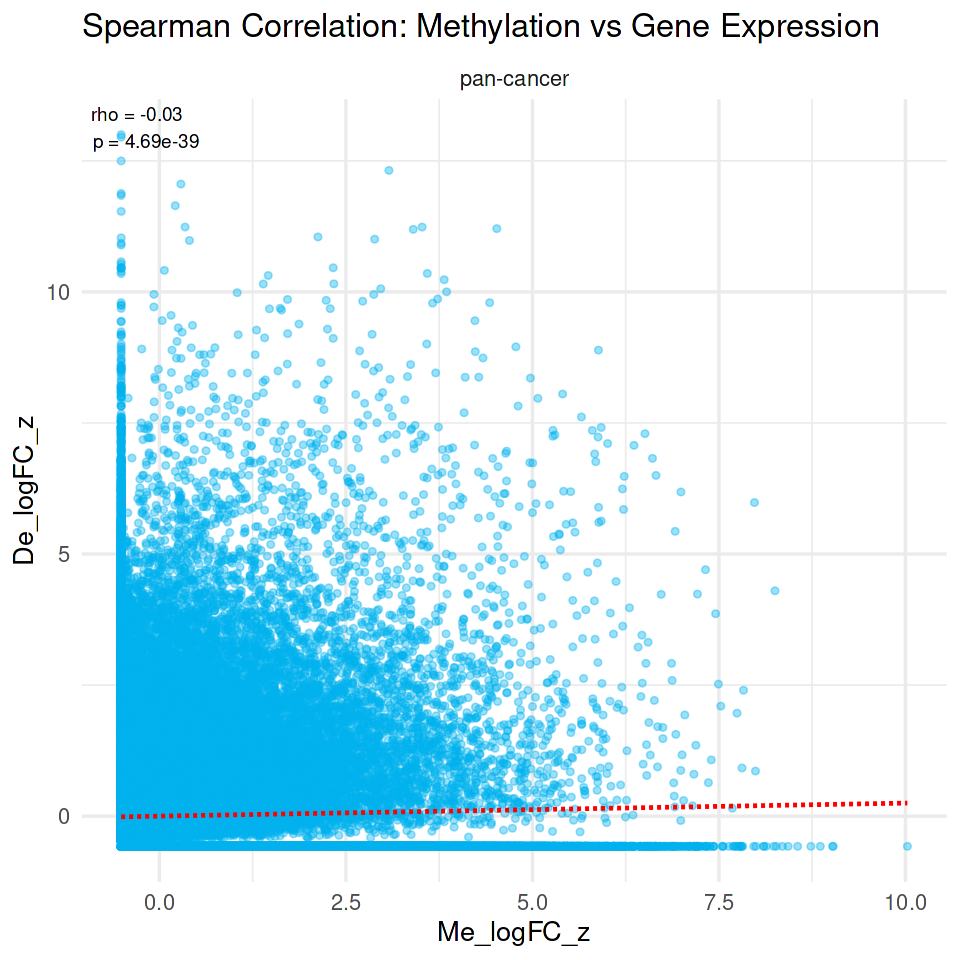

In [32]:
#---------------------------------------------------------------------------------
# Visualization: Scatter plot of methylation vs gene expression
#---------------------------------------------------------------------------------
# Set plot dimensions
options(repr.plot.width = 8, repr.plot.height = 8)
plot_correlation_scatter(data_combined, "Me_logFC_z", "De_logFC_z", corr_results_met_exp_pan_cancer, 
                         "Spearman Correlation: Methylation vs Gene Expression", "pan-cancer")

In [33]:
#---------------------------------------------------------------------------------
# Compute Spearman correlation
#---------------------------------------------------------------------------------
corr_results_met_exp_cancer_type <- 
compute_groupwise_spearman(data_combined, "Me_logFC_z", "De_logFC_z", "cancer_type")
corr_results_met_exp_cancer_type

cancer_type corr         pval         label                    
1  BLCA        -0.089590107 4.284742e-30 rho = -0.09\np = 4.28e-30
2  BRCA         0.094023723 4.949088e-33 rho = 0.09\np = 4.95e-33 
3  CHOL         0.059330047 4.715161e-14 rho = 0.06\np = 4.72e-14 
4  COAD        -0.113218547 3.401852e-47 rho = -0.11\np = 3.40e-47
5  ESCA        -0.017357028 2.752462e-02 rho = -0.02\np = 2.75e-02
6  HNSC        -0.097074344 4.591154e-35 rho = -0.1\np = 4.59e-35 
7  KIRC        -0.010556296 1.801369e-01 rho = -0.01\np = 1.80e-01
8  KIPR         0.007670072 3.298878e-01 rho = 0.01\np = 3.30e-01 
9  LIHC        -0.160445239 1.926371e-93 rho = -0.16\np = 1.93e-93
10 LUAD        -0.059019866 6.355015e-14 rho = -0.06\np = 6.36e-14
11 LUSC        -0.061187940 7.185681e-15 rho = -0.06\np = 7.19e-15
12 PRAD         0.001241502 8.747451e-01 rho = 0\np = 8.75e-01    
13 READ        -0.046361674 3.821515e-09 rho = -0.05\np = 3.82e-09
14 THCA         0.037373456 2.064728e-06 rho = 0.04\np = 2.06e-06 
15 UCEC        -0.048168445 9.002453e-10 rho = -0.05\np = 9.00e-10

`geom_smooth()` using formula = 'y ~ x'


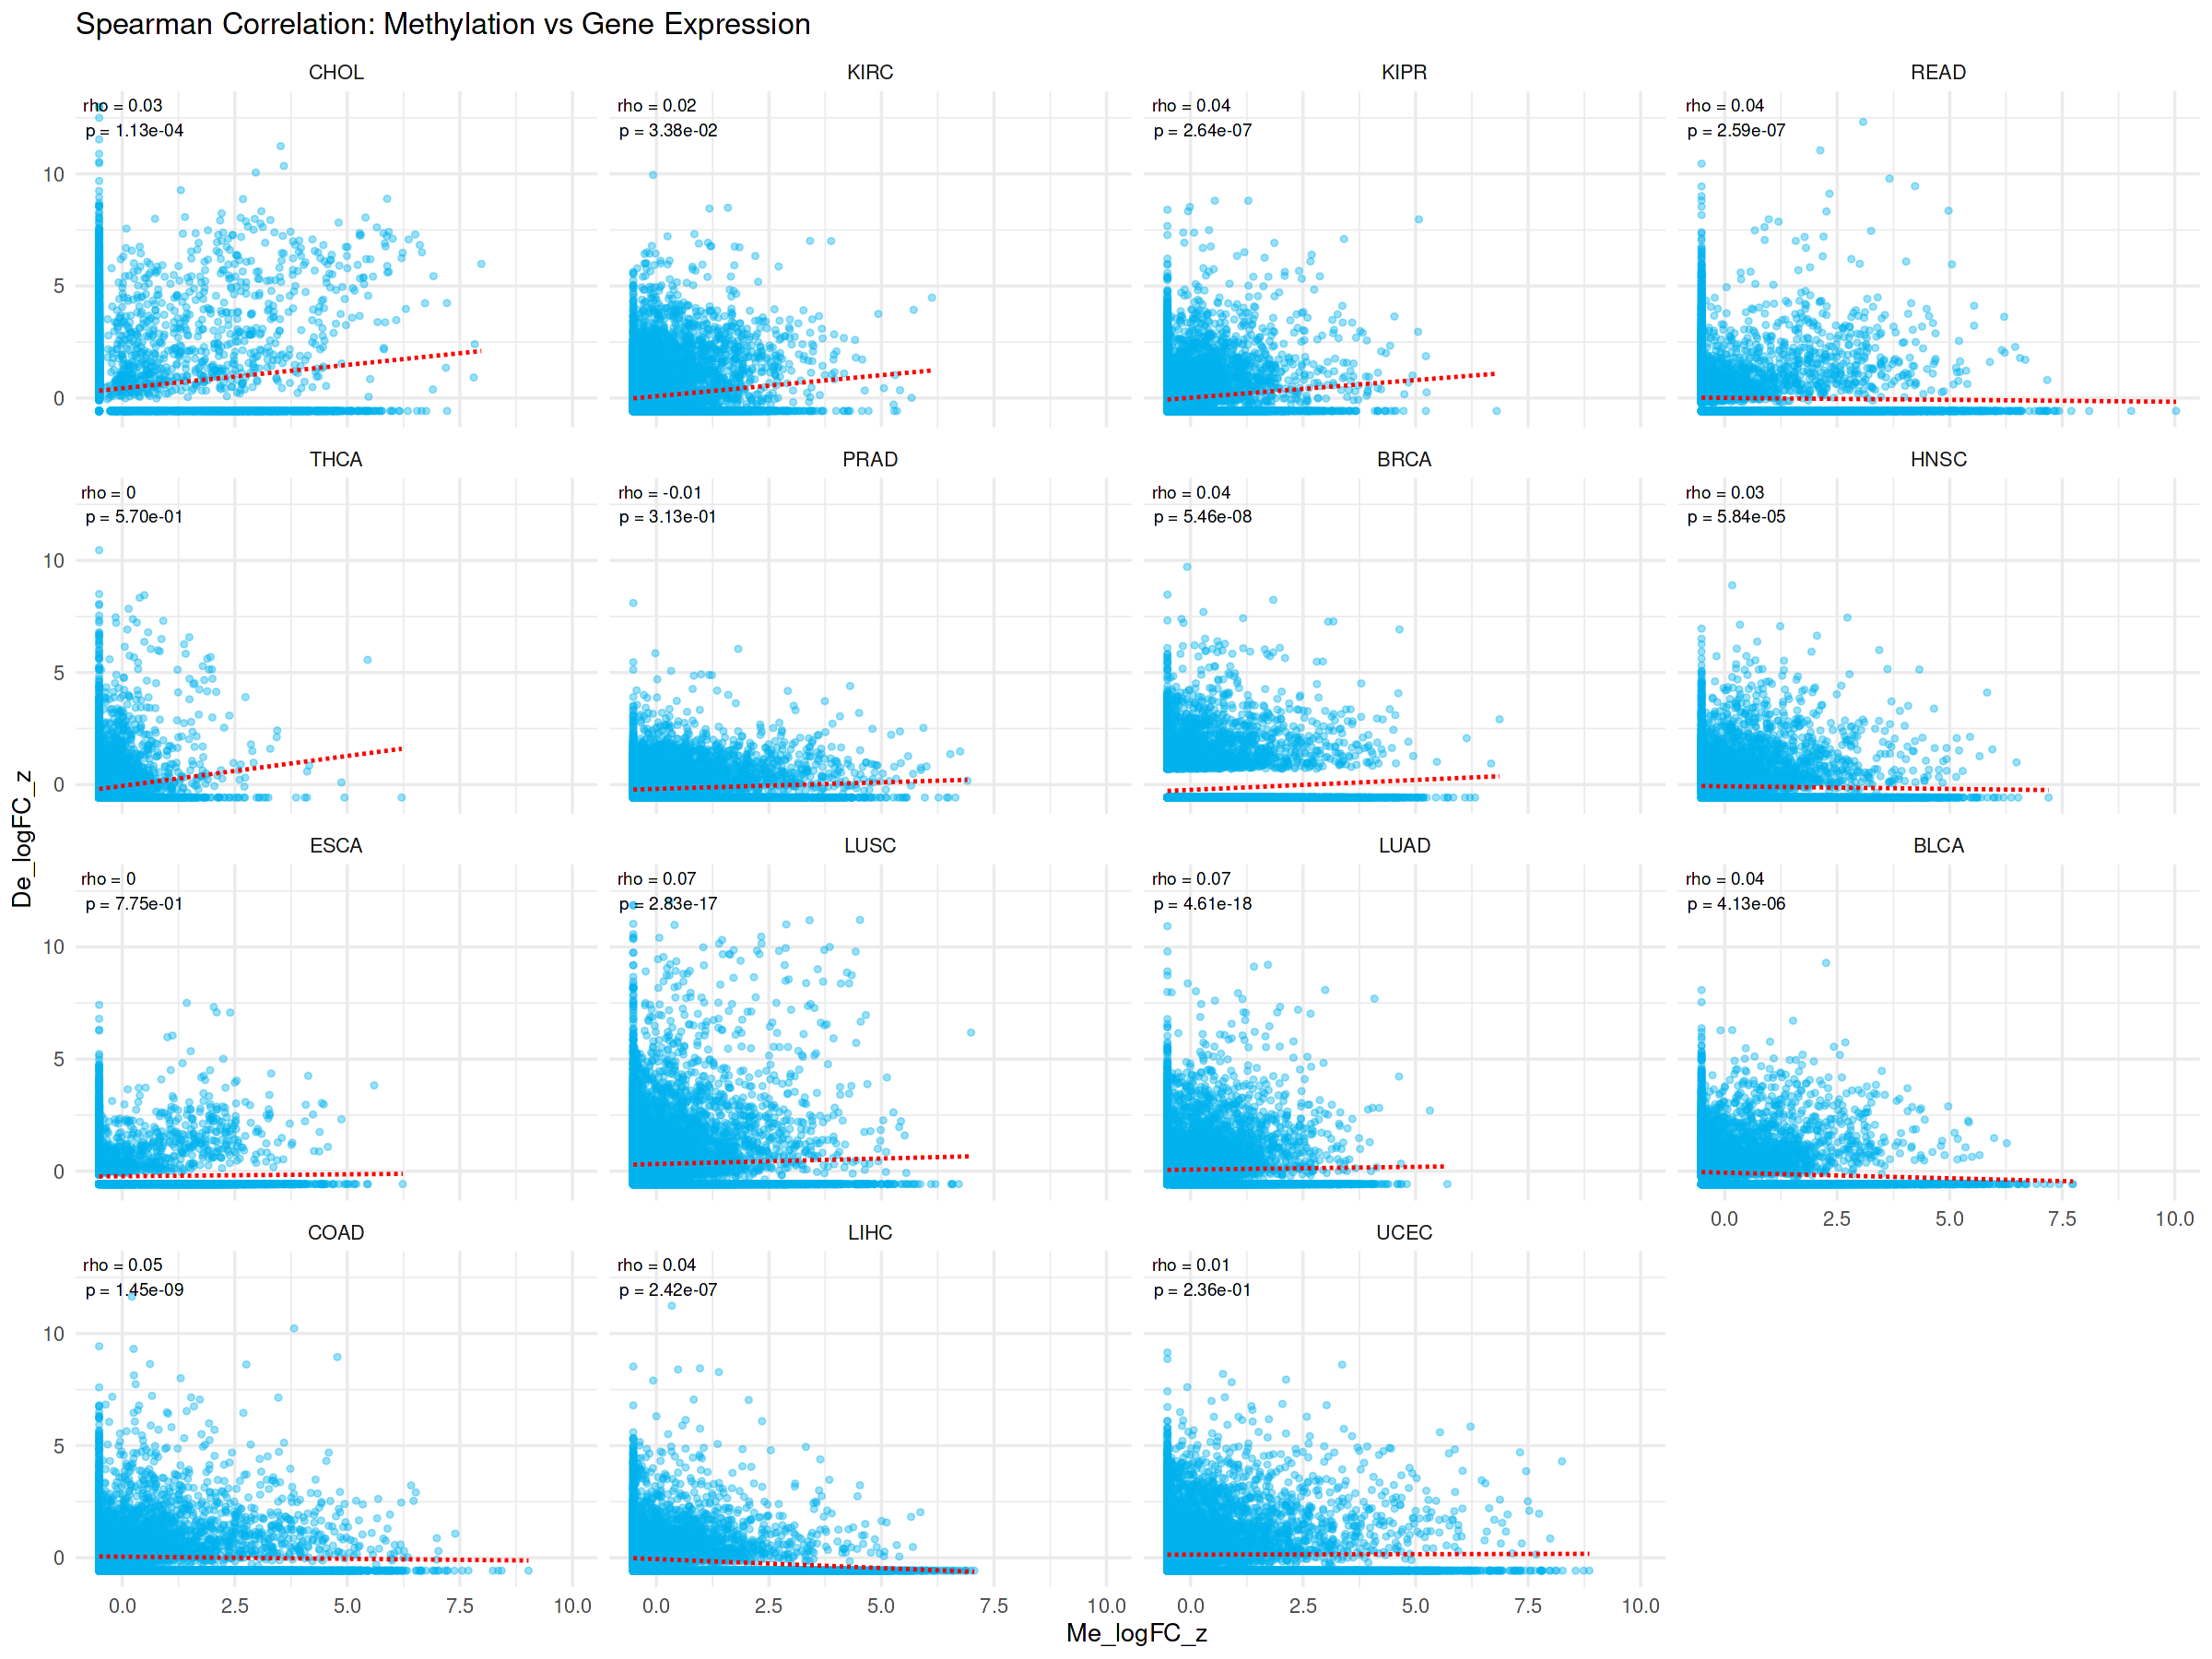

In [34]:
#---------------------------------------------------------------------------------
# Visualization: Scatterplot of methylation vs expression per cancer type
#---------------------------------------------------------------------------------

# Set figure size
options(repr.plot.width = 20, repr.plot.height = 15)
plot_correlation_scatter(data_combined, "Me_logFC_z", "De_logFC_z", corr_results_cnv_exp_cancer_type, 
                         "Spearman Correlation: Methylation vs Gene Expression", "cancer_type")

### Key Inferences

- CNV burden can impact gene expression by altering gene dosage, which may drive cancer progression or therapy response. Assessing this relationship helps clarify how much widespread copy number alterations collectively affect gene expression changes across tumors
- The reported Spearman's rho indicates a very weak (almost negligible) monotonic relationship between CNV burden and the number of expression-perturbed genes. This means that, across the whole dataset (pan-cancer), tumors with higher CNV burden don't consistently show many more or fewer genes with altered expression than tumors with lower burden
- None of the cancer types show a strong monotonic association between CNV burden and gene expression perturbation. Even in the best case (rho ~0.07), the relationship is very weak, suggesting that CNV burden alone is not a major driver of gene expression changes at the global level within any single tumor type.
- There is not a strong global relationship between methylation and expression patterns. The increased methylation is not consistently associated with lower gene expression for all genes and samples combined in the pan-cancer analysis-at least, not strongly enough to be statistically meaningful (values close to 0 indicate no linear or monotonic association)
- In case of cancer types as well the observed coorelation is very close to zero, suggesting that, there is almost no meaningful relationship between methylation and expression across the genes and samples analyzed.



<a id='task4'></a>
# Task 4: Statistical Testing

**Assignment requirement:**  
- Test whether genes with CNV_2 > 0 have higher expression logFC.  
- Test whether genes with CNV_-2 > 0 have lower expression logFC.


In [35]:
# ----------------------------------------------------------
# Impact of CNV amplification (CNV 2) on gene expression |logFC|
# ----------------------------------------------------------

# Create grouping variable based on CNV amplification status
#    1. "Amplified" if CNV_2 > 0
#    2. "NotAmplified" otherwise
data_combined[, CNVAmpGroup := ifelse(CNV_2 > 0, "Amplified", "NotAmplified")]

# Perform Wilcoxon rank-sum test (Mann–Whitney U test)
#    1. Non-parametric test, suitable for skewed expression data
#    2. Tests whether the distribution of |logFC| differs between the two groups
wilcox_amp <- wilcox.test(`De_|logFC|` ~ CNVAmpGroup, data = data_combined)
wilcox_amp


	Wilcoxon rank sum test with continuity correction

data:  De_|logFC| by CNVAmpGroup
W = 6.984e+09, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


There is a statistically significant difference in expression |logFC| between genes with CNV amplification and those without. Inticating the gene amplification is strongly associated with higher or lower expression in the data.

Picking joint bandwidth of 0.0405



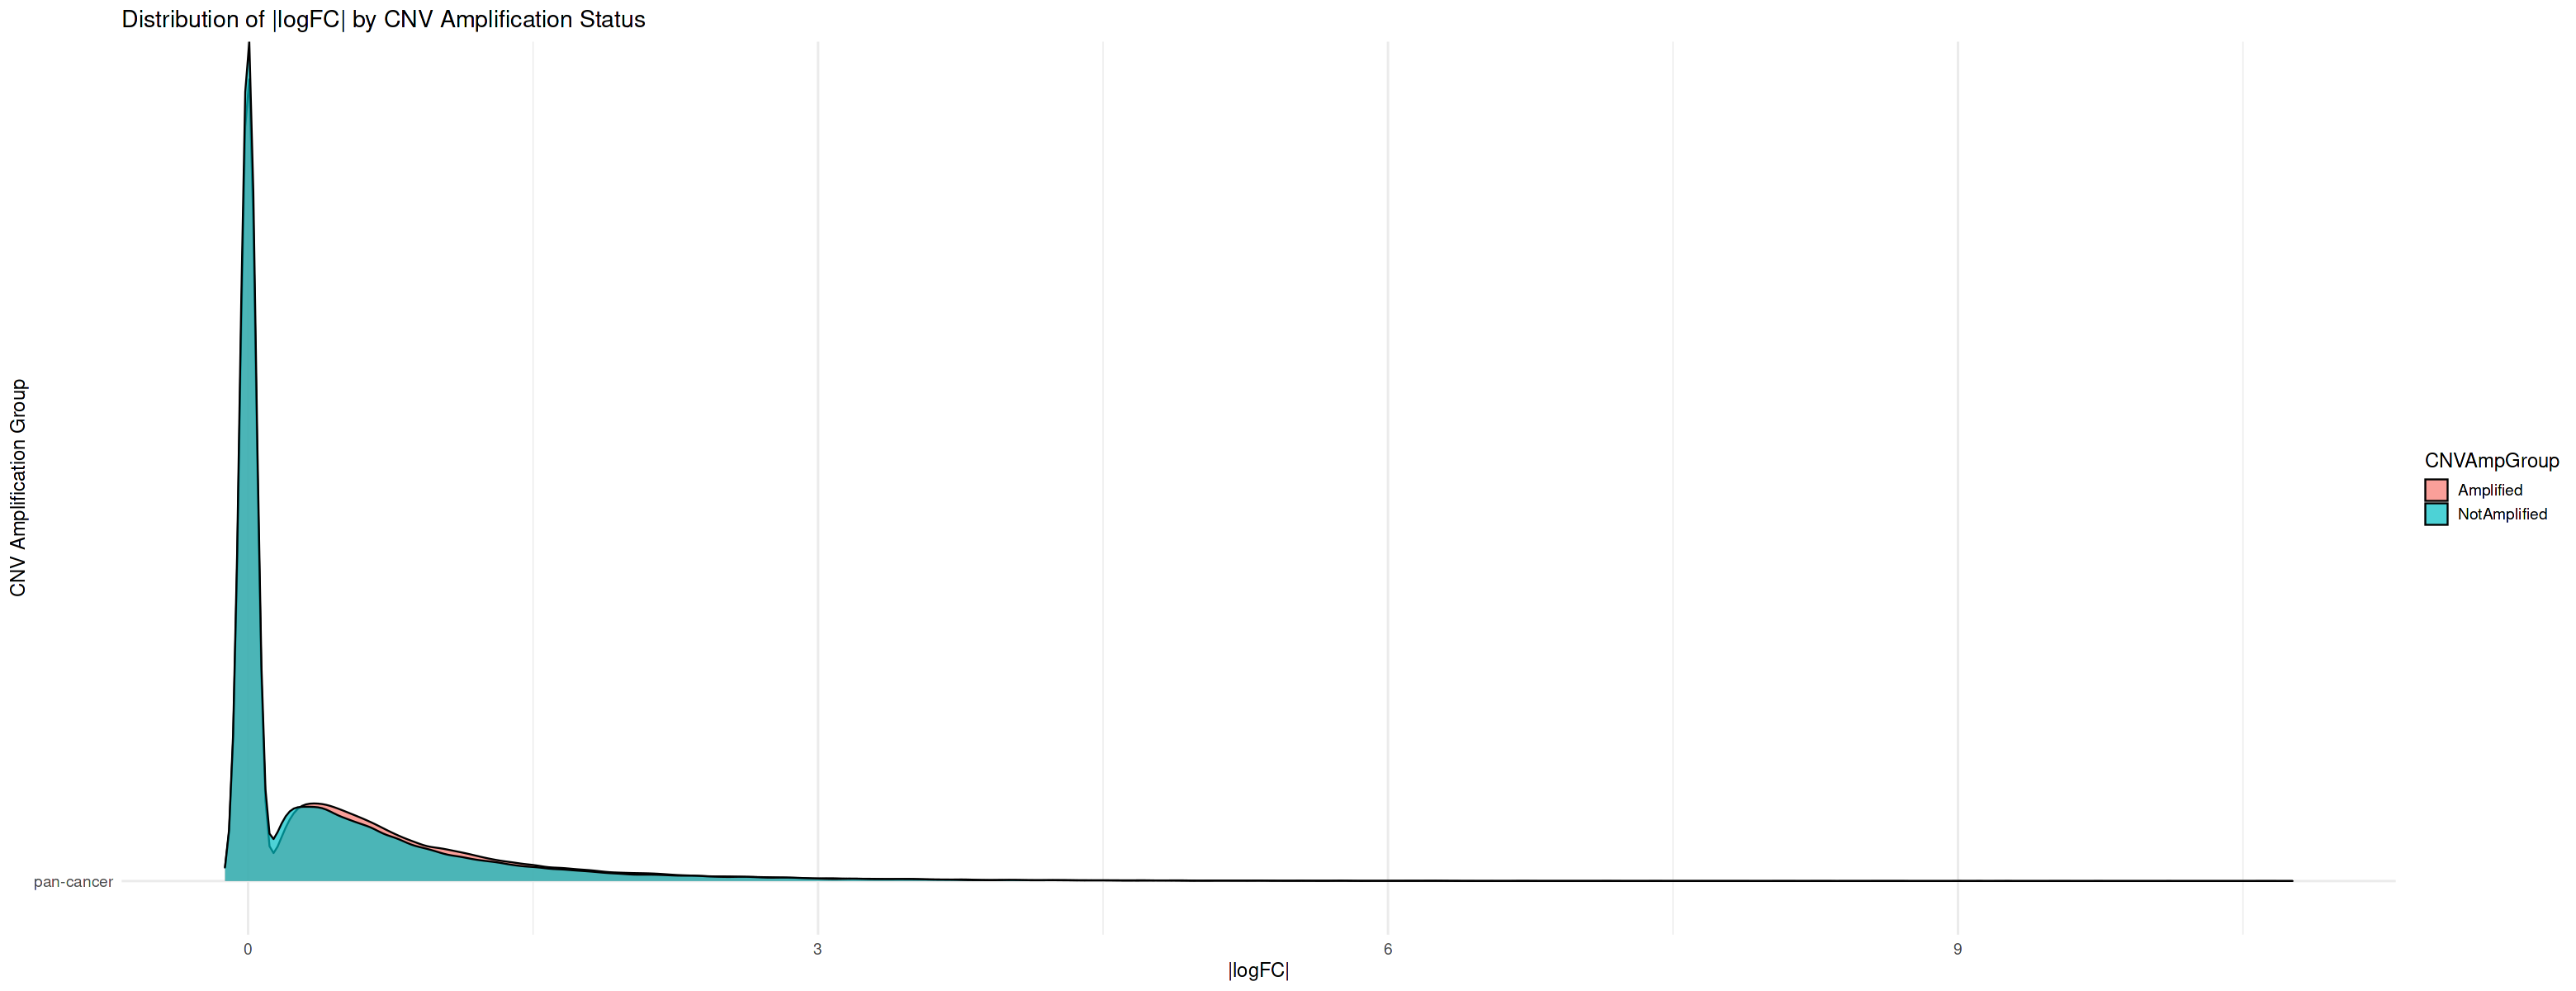

In [36]:
options(repr.plot.width = 26, repr.plot.height = 10)
ggplot(data_combined, aes(x = `De_|logFC|`, y = 'pan-cancer', fill = CNVAmpGroup)) +
  geom_density_ridges(alpha = 0.7) +
  labs(
    title = "Distribution of |logFC| by CNV Amplification Status",
    x = "|logFC|",
    y = "CNV Amplification Group"
  ) +
  theme_minimal(base_size = 14)

In [37]:
#---------------------------------------------------------------------------------
# Impact of CNV deletion (CNV -2) on gene expression (|logFC|)
#---------------------------------------------------------------------------------

# Create grouping variable based on CNV deletion status:
# - "Deleted"     if CNV_-2 > 0
# - "NotDeleted"  otherwise
data_combined[, CNVDelGroup := ifelse(`CNV_-2` > 0, "Deleted", "NotDeleted")]

# Perform Wilcoxon rank-sum test (Mann–Whitney U test)
# - Non-parametric test, suitable for skewed data
# - Tests whether the distribution of |logFC| differs between groups
wilcox_del <- wilcox.test(`De_|logFC|` ~ CNVDelGroup, data = data_combined)
wilcox_del


	Wilcoxon rank sum test with continuity correction

data:  De_|logFC| by CNVDelGroup
W = 7309217058, p-value = 0.1418
alternative hypothesis: true location shift is not equal to 0


There is no statistically significant difference in expression |logFC| between genes classified as "Deleted" and those classified as "Not Deleted"


Picking joint bandwidth of 0.041



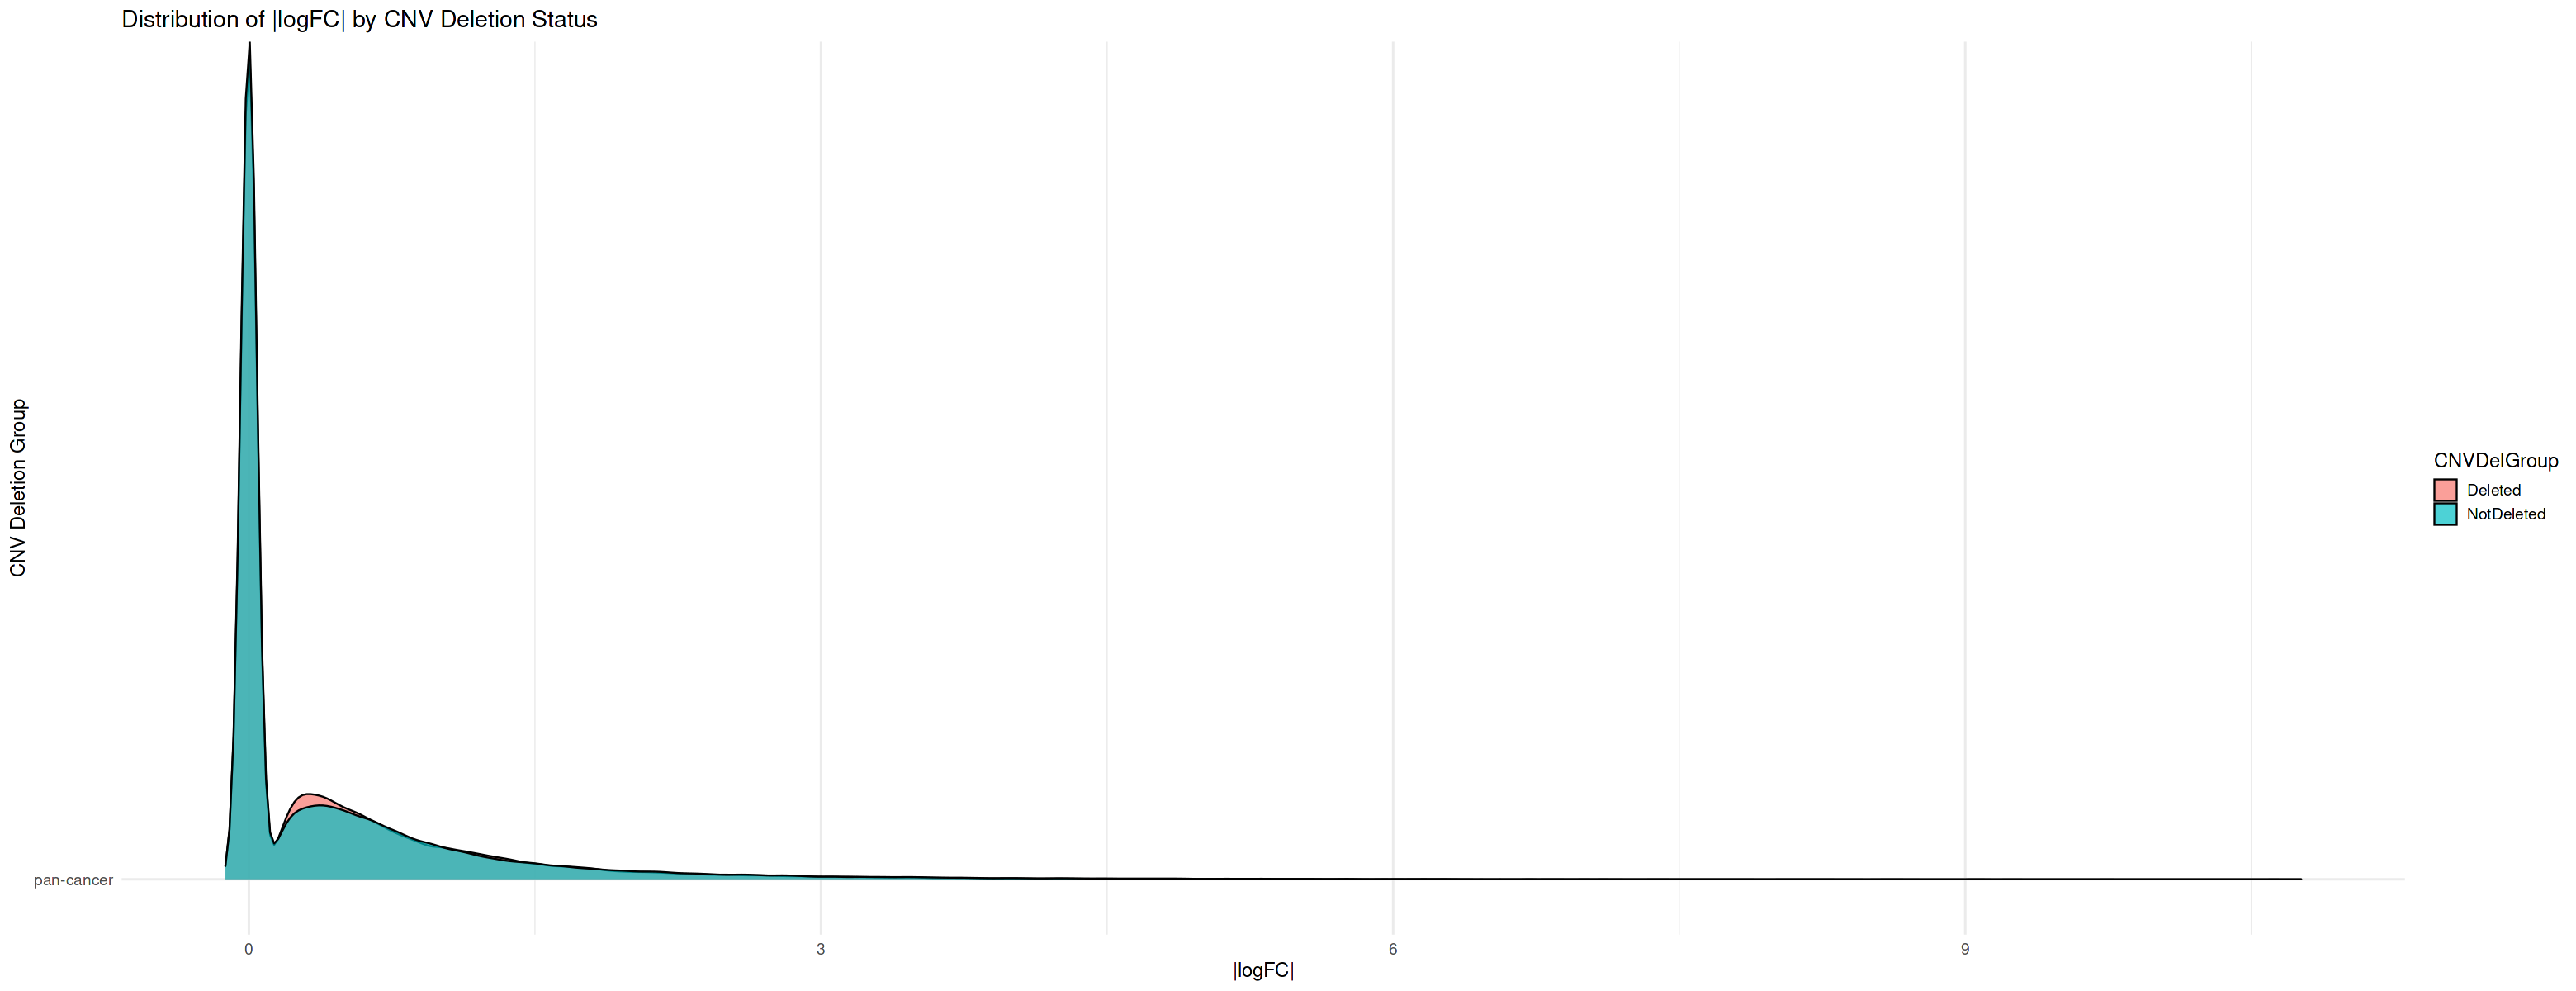

In [38]:
options(repr.plot.width = 26, repr.plot.height = 10)
ggplot(data_combined, aes(x = `De_|logFC|`, y = 'pan-cancer', fill = CNVDelGroup)) +
  geom_density_ridges(alpha = 0.7) +
  labs(
    title = "Distribution of |logFC| by CNV Deletion Status",
    x = "|logFC|",
    y = "CNV Deletion Group"
  ) +
  theme_minimal(base_size = 14)

### Key Inferences

- The amplification group shows a statistically significant difference in |logFC|, indicating that CNV amplification is associated with measurable changes in gene expression.
- The Wilcoxon rank-sum test is rank-based, so even a subtle but consistent shift in the distribution can be detected as significant when the sample size is large.
- In this case, the distributions are visually similar, but the small shift in amplified genes is sufficient to yield a very low p-value.
- Deletion groups show no such shift, resulting in a non-significant p-value, suggesting little to no systematic impact on expression.


<a id='task5'></a>
# Task 5: Visualization Deliverables

**Assignment requirement:**  
- Histogram of mutation frequencies  
- Heatmap of CNV values for top 50 most variable genes  
- Volcano plots for methylation and expression  
- Scatterplot of methylation vs expression |logFC|


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`).”


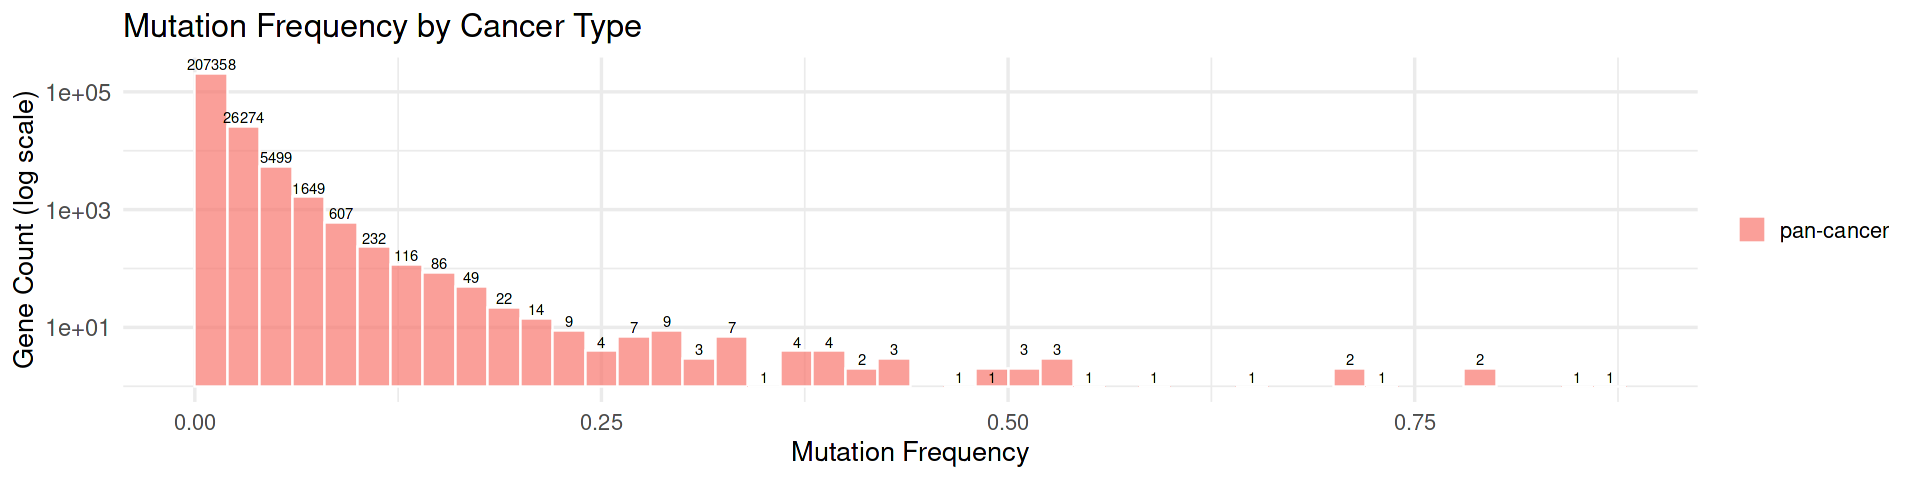

In [39]:
#---------------------------------------------------------------------------------
# Plot mutation frequency distribution as a histogram with log-scaled counts
#---------------------------------------------------------------------------------

# Define bin width for histogram and bin the mutation frequency values and count occurrences
binwidth <- 0.02

dt_bins <- copy(data_combined)
dt_bins[, bin := cut(
  Mutation_frequency, 
  breaks = seq(0, 1, by = binwidth), 
  include.lowest = TRUE, 
  right = FALSE
)]
dt_counts <- dt_bins[, .N, by = bin]

#---------------------------------------------------------------------------------
# Calculate bin centers for placing count labels on top of histogram bars
#---------------------------------------------------------------------------------
dt_counts[, bin_start := as.numeric(gsub("\\[|\\(|,.*", "", bin))]
dt_counts[, bin_center := bin_start + binwidth / 2]

#---------------------------------------------------------------------------------
# Plot histogram of mutation frequencies
#---------------------------------------------------------------------------------
options(repr.plot.width = 16, repr.plot.height = 4)

ggplot(data_combined, aes(x = Mutation_frequency, fill = `pan-cancer`)) +
  geom_histogram(binwidth = binwidth, color = "white", alpha = 0.7, boundary = 0) +
  
  # Overlay bin counts as text labels
  geom_text(data = dt_counts,
    aes(x = bin_center, y = N, label = N),
    vjust = -0.3, size = 3, color = "black",inherit.aes = FALSE) +
  
  # Log scale on Y-axis for better visibility of skewed distributions
  scale_y_log10() +

  # Add axis labels and theme elements.
  labs(
    title = "Mutation Frequency by Cancer Type",
    x = "Mutation Frequency",
    y = "Gene Count (log scale)") +
  theme_minimal(base_size = 16) +
  theme(legend.title = element_blank(), axis.text.y = element_text(size = 14))


In [40]:
#---------------------------------------------------------------------------------
# Identify and visualize Top genes with highest CNV frequency per cancer type
#---------------------------------------------------------------------------------

# Extract Top 5 genes per cancer type based on CNV frequency
top5_per_cancer <- cnv_df[rev(order(CNV_frequency)), .SD[1:5], by = cancer_type]

# Subset data for only those Top 5 genes across all cancer types
top5_per_cancer_df <- subset(cnv_df, Gene %in% top5_per_cancer$Gene)

In [41]:
#---------------------------------------------------------------------------------
# Order genes and cancer types by their mean CNV frequency for better visualization
#---------------------------------------------------------------------------------

# Order genes by mean CNV frequency (descending)
gene_order <- top5_per_cancer_df[
  , .(mean_freq = mean(CNV_frequency, na.rm = TRUE)),
  by = Gene
][rev(order(mean_freq)), Gene]

# Order cancer types by mean CNV frequency (descending)
cancer_order <- top5_per_cancer_df[
  , .(mean_freq = mean(CNV_frequency, na.rm = TRUE)),
  by = cancer_type
][rev(order(mean_freq)), cancer_type]

# Set factor levels to enforce this order in the plot
top5_per_cancer_df[, Gene := factor(Gene, levels = gene_order)]
top5_per_cancer_df[, cancer_type := factor(cancer_type, levels = cancer_order)]

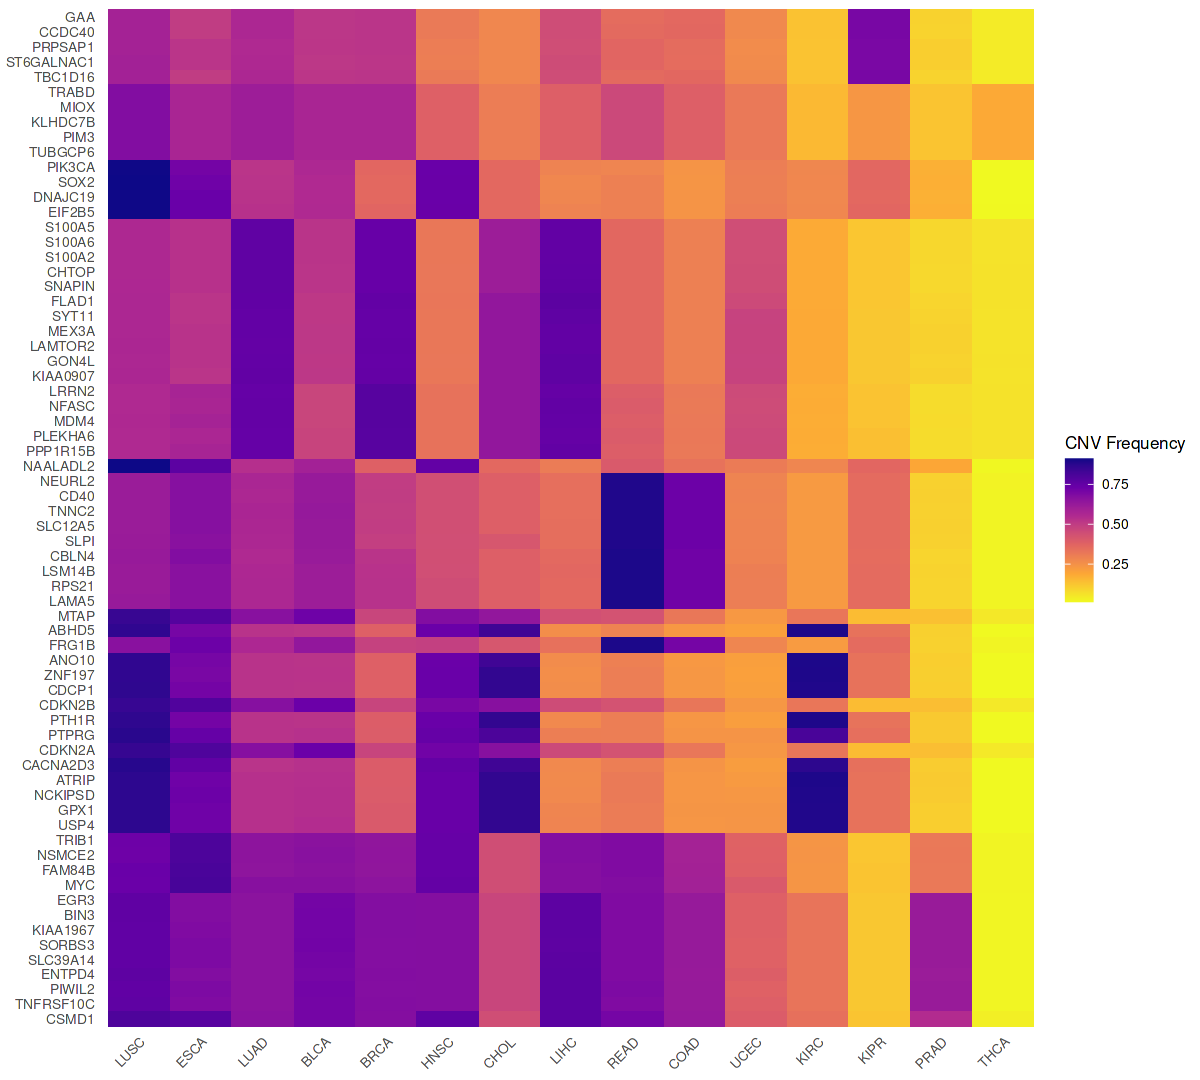

In [42]:
#---------------------------------------------------------------------------------
# Visualization: Heatmap of top 5 genes per cancer type based on CNV frequency
#---------------------------------------------------------------------------------
options(repr.plot.width = 10, repr.plot.height = 9)

ggplot(top5_per_cancer_df, aes(x = cancer_type, y = Gene, fill = CNV_frequency)) +
  geom_tile() +
  scale_fill_viridis_c(option = "plasma", direction = -1) +
  labs(fill = "CNV Frequency") +
  theme_minimal(base_size = 10) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title = element_blank(),
    panel.grid = element_blank()
  )

In [43]:
#---------------------------------------------------------------------------------
# Identify and visualize Top 50 most variable genes based on CNV frequency across cancers
#---------------------------------------------------------------------------------

# Variance helps identify genes with the most variability in CNV frequency across cancer types.
gene_var <- cnv_df[, .(variance = var(CNV_frequency)), by = Gene]

# Select Top 50 genes with highest CNV frequency variance
top50_variable <- gene_var[order(-variance)][1:50]

# Subset the CNV data for only these top 50 variable genes
top50_variable_df <- subset(cnv_df, Gene %in% top50_variable$Gene)

In [44]:
#---------------------------------------------------------------------------------
# Compute mean CNV frequency for ordering genes and cancer types in the heatmap
#---------------------------------------------------------------------------------

# Order genes by their mean CNV frequency (descending)
gene_order <- top50_variable_df[
  , .(mean_freq = mean(CNV_frequency, na.rm = TRUE)),
  by = Gene
][rev(order(mean_freq)), Gene]

# Order cancer types by their mean CNV frequency (descending)
cancer_order <- top50_variable_df[
  , .(mean_freq = mean(CNV_frequency, na.rm = TRUE)),
  by = cancer_type
][rev(order(mean_freq)), cancer_type]

# Set factor levels for consistent ordering in the plot
top50_variable_df[, Gene := factor(Gene, levels = gene_order)]
top50_variable_df[, cancer_type := factor(cancer_type, levels = cancer_order)]

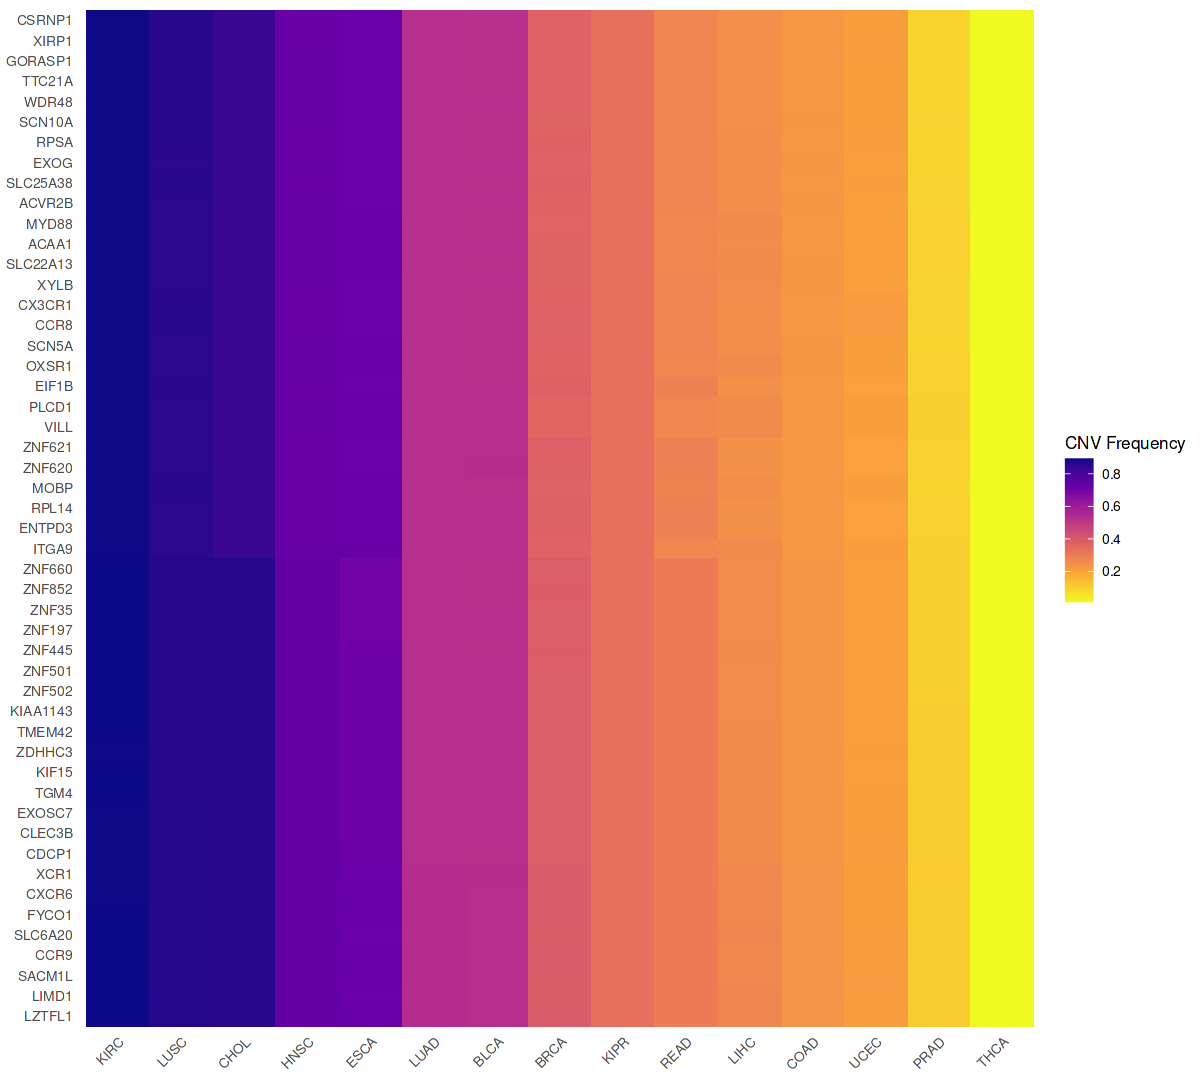

In [45]:
#---------------------------------------------------------------------------------
# Visualization - Heatmap of Top 50 most variable genes
#---------------------------------------------------------------------------------
options(repr.plot.width = 10, repr.plot.height = 9)

ggplot(top50_variable_df, aes(x = cancer_type, y = Gene, fill = CNV_frequency)) +
  geom_tile() +
  scale_fill_viridis_c(option = "plasma", direction = -1) +
  labs(fill = "CNV Frequency") +
  theme_minimal(base_size = 10) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title = element_blank(),
    panel.grid = element_blank()
  )

In [46]:
#---------------------------------------------------------------------------------
# Volcano Plot
# Highlighting key genes with significant changes in both methylation and expression
#---------------------------------------------------------------------------------

# Identify key genes based on significance and effect size thresholds
# Criteria:
# - Significant methylation change (Me_adj.P-value < 0.05)
# - Significant expression change (De_adj.P-value < 0.05)
# - Absolute methylation logFC Zscore >= 2
# - Absolute expression logFC Zscore >= 2
keyGenes <- data_combined[
  (`Me_adj.P-value` < 0.05) &
  (`De_adj.P-value` < 0.05) &
  (abs(Me_logFC_z) >= 2) &
  (abs(De_logFC_z) >= 2),
  .SD[order(-Me_logFC_z)],
  by = cancer_type]

# Clean key gene list
# Remove rows with NA values (if any)
keyGenes <- keyGenes[!which(is.na(keyGenes))]

# Count number of unique genes meeting the criteria
unique_gene_count <- uniqueN(keyGenes$Gene)
unique_gene_count

[1] 822

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '−Log10 adjusted P-value' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '−Log10 adjusted P-value' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '−Log10 adjusted P-value' in 'mbcsToSbcs': dot substituted for <92>”
Warning message:
“ggrepel: 258 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 46 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 89 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 62 unlabeled data point

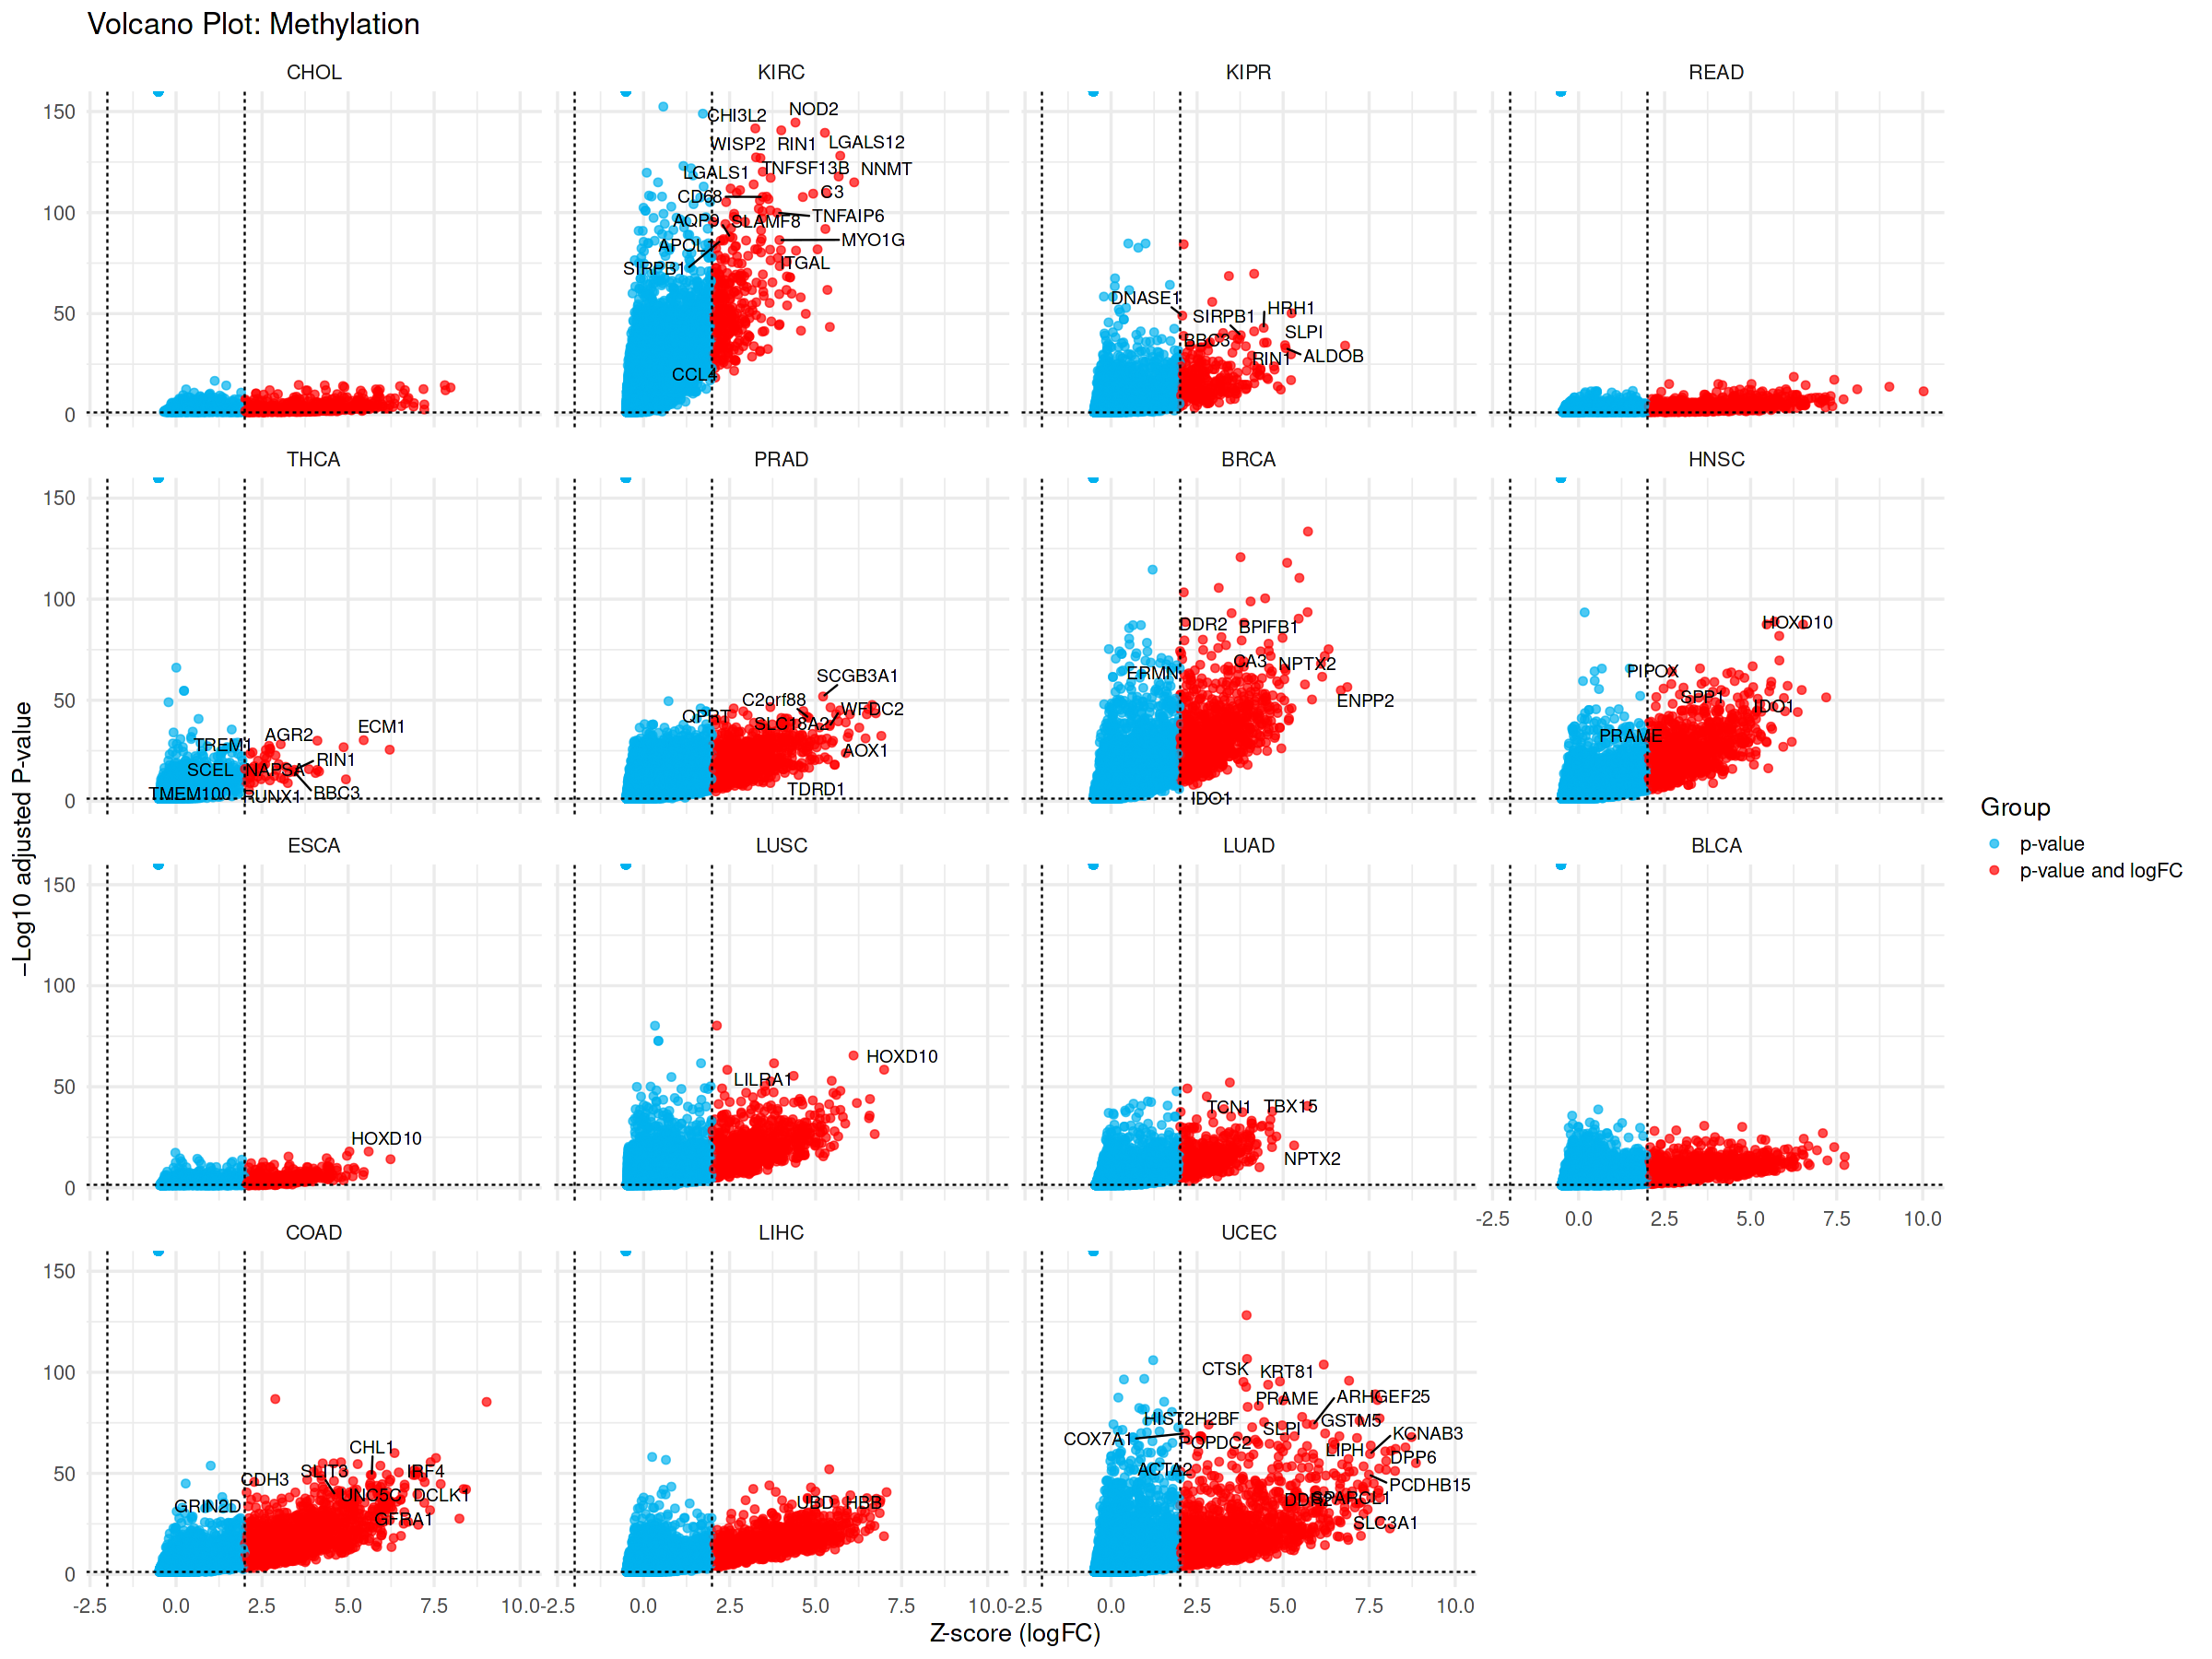

In [47]:
#---------------------------------------------------------------------------------
# Visualization - Methylation Data
#---------------------------------------------------------------------------------
options(repr.plot.width = 20, repr.plot.height = 15)

plot_volcano(
  data = data_combined,
  pv = "Me_adj.P-value",
  fcz = "Me_logFC_z",
  title = "Methylation",
  fc_thresh = 2,
  pv_thresh = 0.05,
  keyGenes = keyGenes
)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '−Log10 adjusted P-value' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '−Log10 adjusted P-value' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '−Log10 adjusted P-value' in 'mbcsToSbcs': dot substituted for <92>”
Warning message:
“ggrepel: 258 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 46 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 88 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 65 unlabeled data point

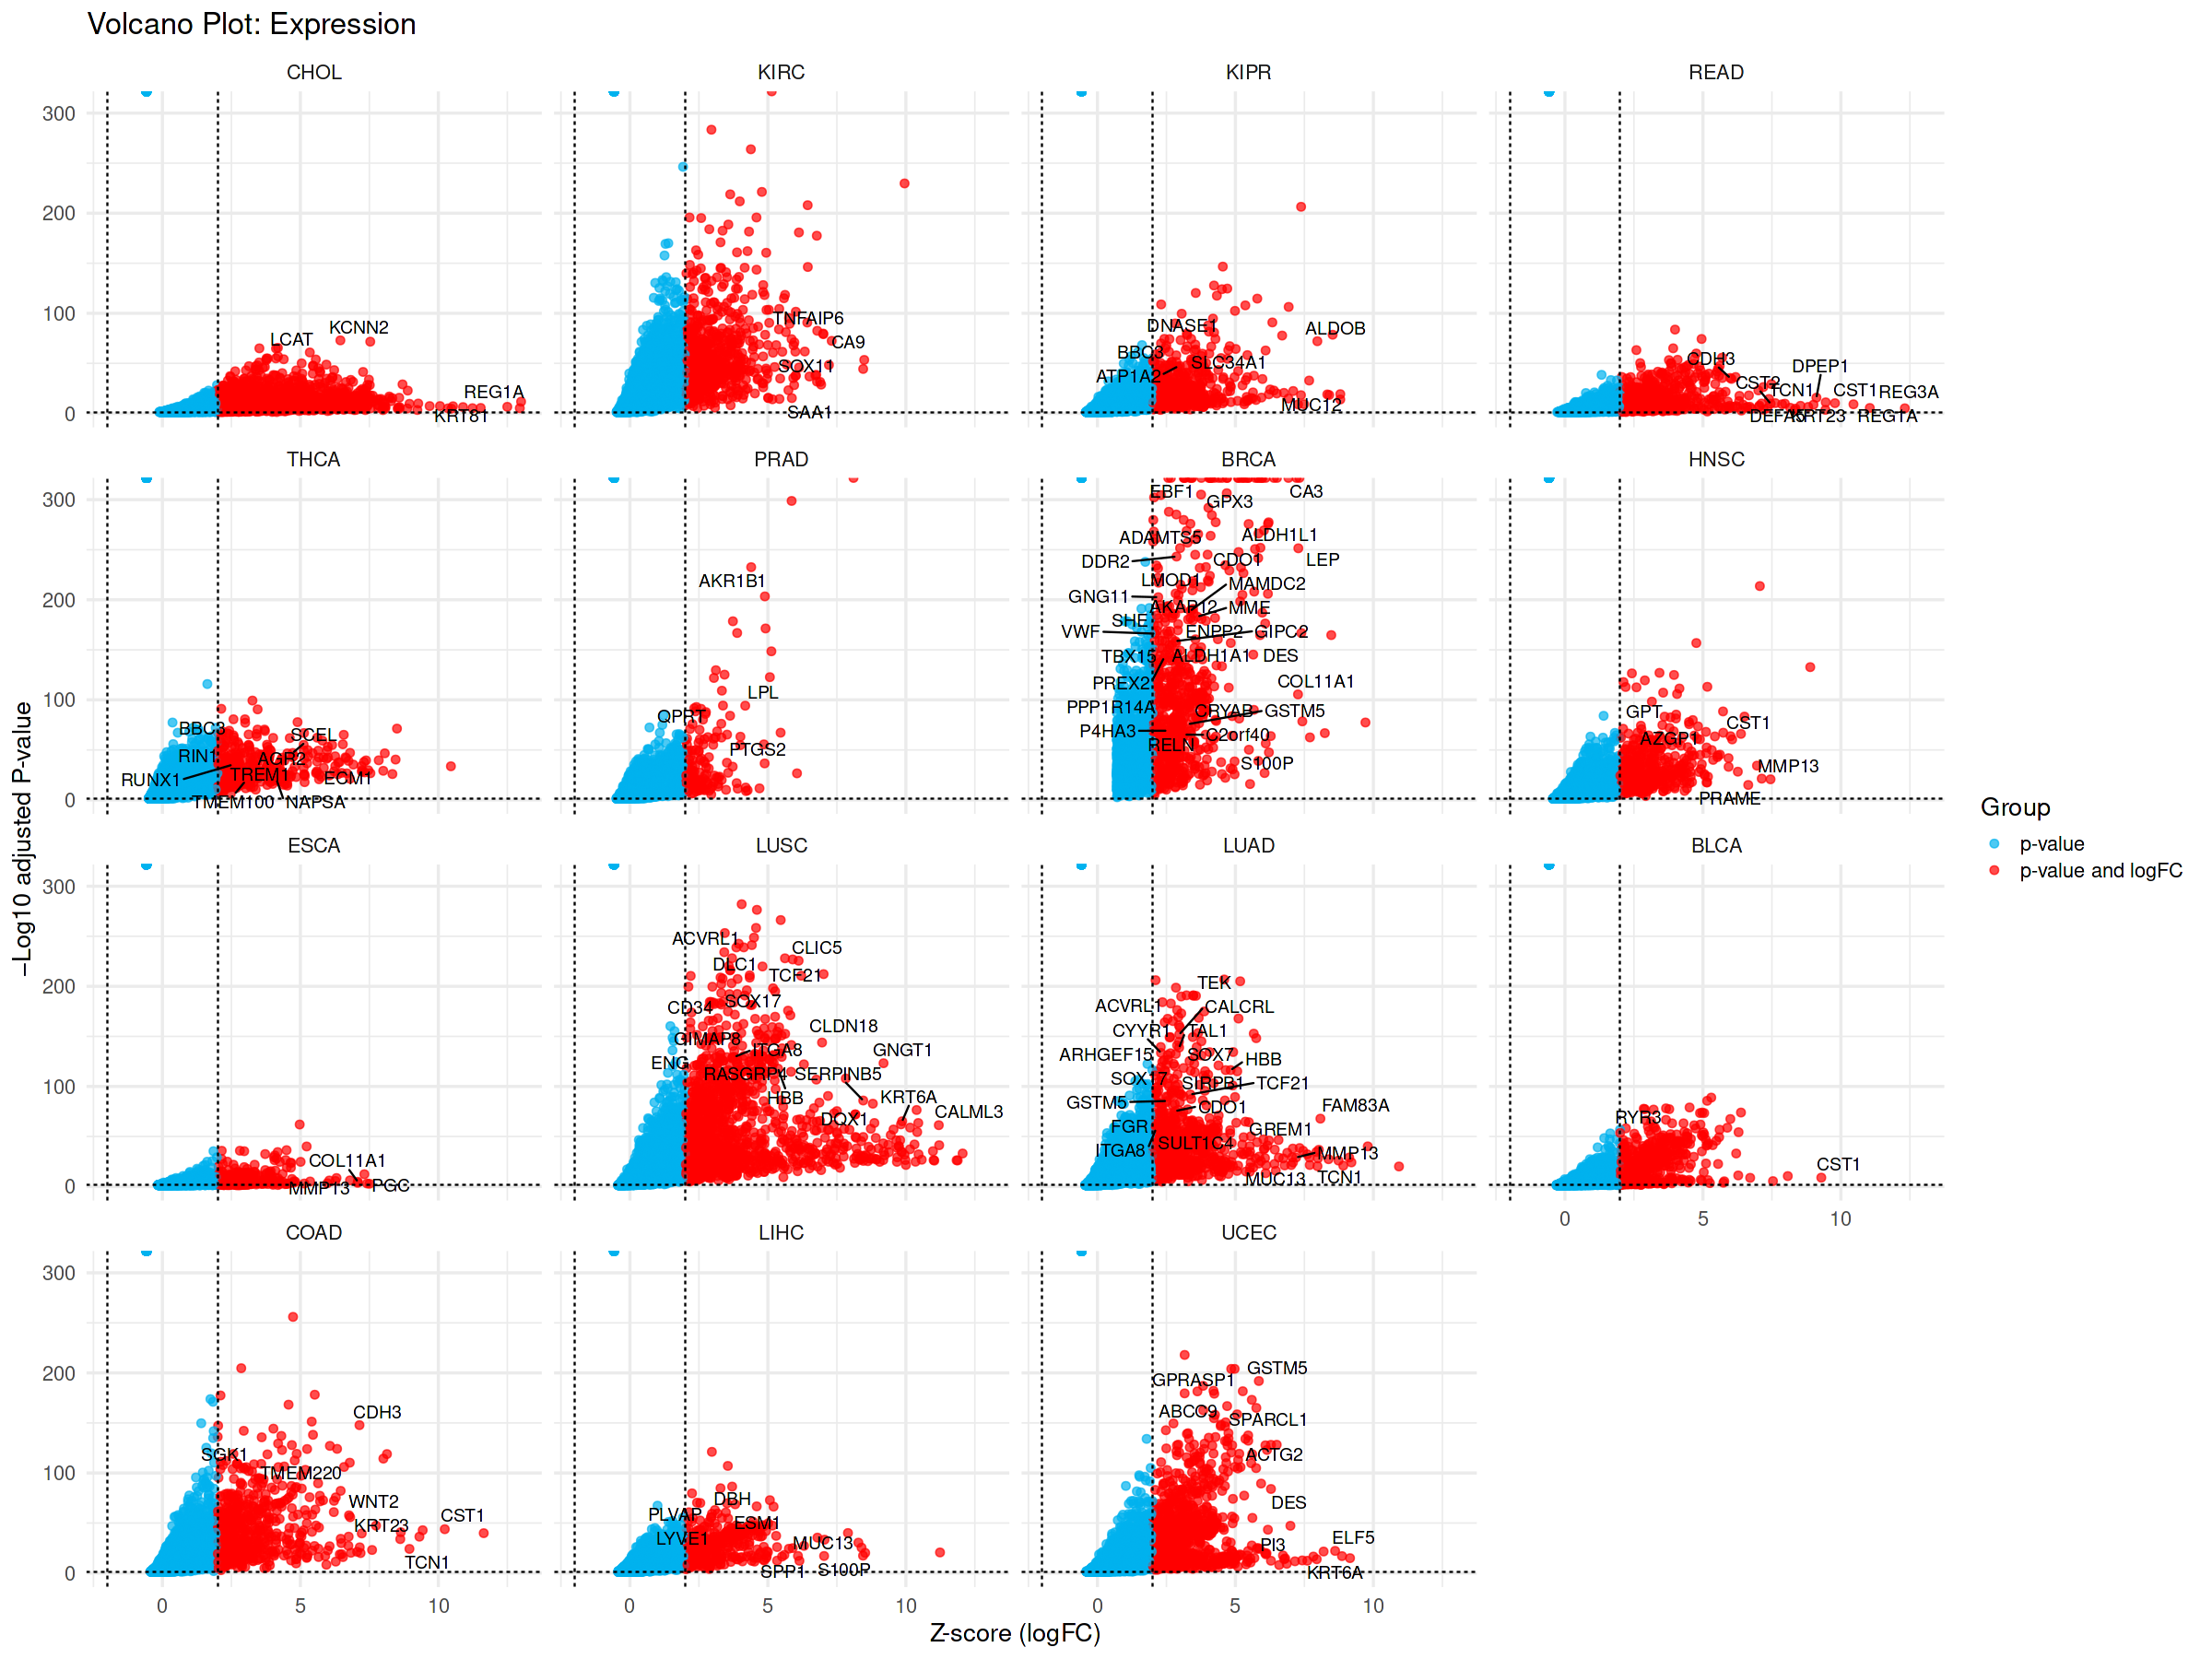

In [48]:
#---------------------------------------------------------------------------------
# Visualization - Expression Data
#---------------------------------------------------------------------------------
options(repr.plot.width = 20, repr.plot.height = 15)

plot_volcano(
  data = data_combined,
  pv = "De_adj.P-value",
  fcz = "De_logFC_z",
  title = "Expression",
  fc_thresh = 2,
  pv_thresh = 0.05,
  keyGenes = keyGenes
)

> The scatterplot of methylation vs expression |logFC| is covered in [Task 3](#task3)

### Key Inferences

- The histogram indicates that most genes exhibit very low mutation frequencies, with a long tail of a few highly mutated genes, which is a characteristic pattern commonly observed in cancer genomics.
- The heatmap analysis of top CNV genes was performed using two approaches:
    - Selecting the top 5 genes with the highest CNV frequency in each cancer type.
    - Identifying the top 50 most variable genes based on CNV frequency variance across cancer types.
- By sorting the selected genes and cancer types by their mean CNV frequency, we could highlight genes showing strong variability between cancers, which may serve as potential marker CNV events for specific cancer types.
- A visual grouping of LUAD, BLCA, and HNSC and another cluster involving ESCA, KIRC, LUSC, and CHOL was observed in the top 50 variance CNV heatmap. While this may reflect similarities in CNV patterns, these are exploratory observations and should be interpreted cautiously. Further clustering (PCA ir t-SNE/UMAP) and statistical validation would be needed to confirm whether these patterns represent biologically meaningful groupings
- The volcano plots highlighted significantly differentially regulated genes, providing a basis for downstream comparative analysis across cancer types and integration with methylation and expression datasets for deeper functional insights.


<a id='task6'></a>
# Task 6: Reporting

**Assignment requirement:**  
Write a short 2–3 page summary covering:
- Key observations from analysis  
- Notable genes with multiple alterations (CNV + methylation + expression)  
- Cancer-type specific patterns.

> Key observations are summarized as "Ket Inferences" at the end of each analysis or section. A seperate report compiling these inferences has also been provided

---